In [1]:
import os
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torchvision import transforms  # ✅ 이걸 추가해야 transforms 사용 가능!
import torch
import torch.nn as nn

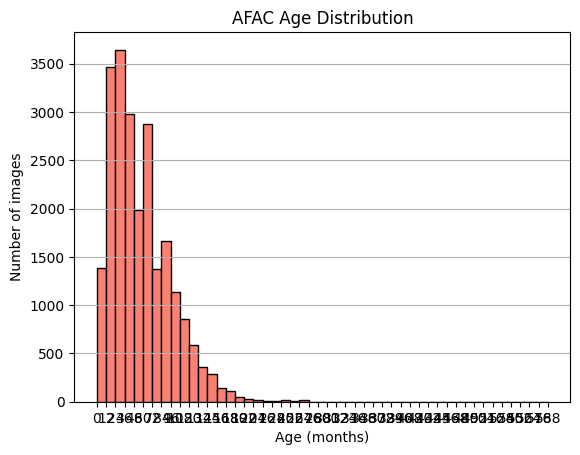

In [1]:
import matplotlib.pyplot as plt

# Age 분포 다시 시각화
with open('AFAC/annotations/train.txt', 'r') as f:
    ages = []
    for line in f:
        try:
            _, age_str = line.strip().split()
            ages.append(int(age_str))
        except:
            continue

plt.hist(ages, bins=range(0, max(ages)+12, 12), color='salmon', edgecolor='black')
plt.xlabel("Age (months)")
plt.ylabel("Number of images")
plt.title("AFAC Age Distribution")
plt.grid(axis='y')
plt.xticks(range(0, max(ages)+12, 12))
plt.show()

⚠️ 잘못된 라인 무시: 
✅ 클래스 분포 (3-Class 기준):
Young: 11629개
Senior: 5292개
Middle: 6079개


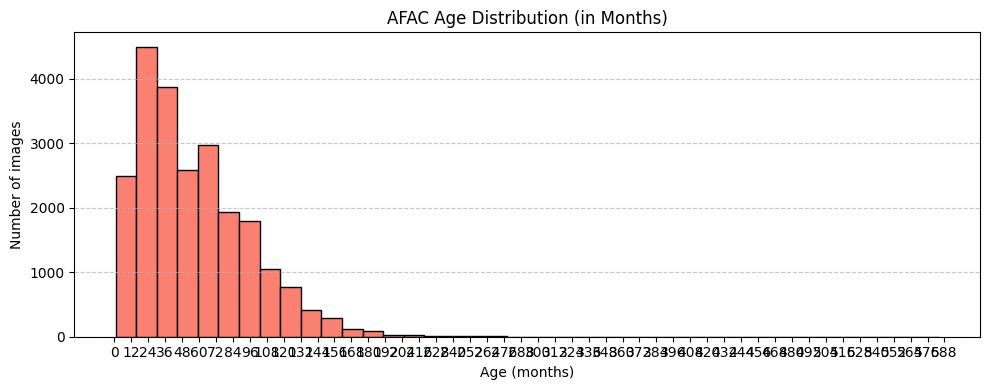

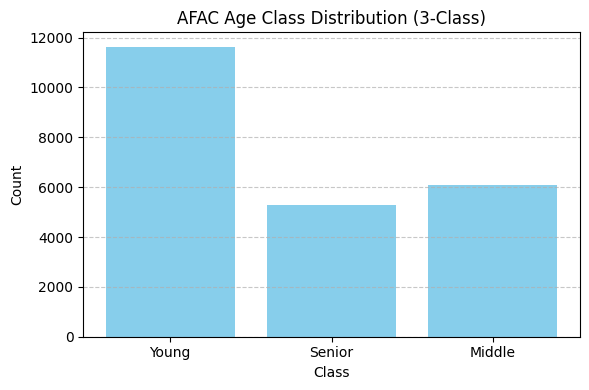

In [2]:
from collections import Counter
import matplotlib.pyplot as plt

# 경로
txt_path = "AFAC/annotations/train.txt"

# 나이 → 클래스 함수 (3-class)
def age_to_class(age_months):
    if age_months <= 48:
        return "Young"
    elif age_months <= 83:
        return "Middle"
    else:
        return "Senior"

# 카운트용 리스트
age_classes = []
age_raw = []

with open(txt_path, 'r') as f:
    for line in f:
        try:
            _, age_str = line.strip().split()
            age = int(age_str)
            age_raw.append(age)
            age_classes.append(age_to_class(age))
        except:
            print(f"⚠️ 잘못된 라인 무시: {line.strip()}")

# 클래스 분포 출력
class_counts = Counter(age_classes)
print("✅ 클래스 분포 (3-Class 기준):")
for cls, count in class_counts.items():
    print(f"{cls}: {count}개")

# 시각화: 연령 분포 히스토그램
plt.figure(figsize=(10, 4))
plt.hist(age_raw, bins=40, color='salmon', edgecolor='black')
plt.title("AFAC Age Distribution (in Months)")
plt.xlabel("Age (months)")
plt.ylabel("Number of images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(0, max(age_raw)+12, 12))
plt.tight_layout()
plt.show()

# 시각화: 클래스 분포
plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("AFAC Age Class Distribution (3-Class)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [3]:
# ================================
# 🐶 AFAC Dataset - Age-based Class Reassignment (2-Class)
# ================================

# 📌 목표:
#   - 강아지의 "노화(Aging)"를 생성 모델이 정확히 학습하도록 클래스 분리
#   - Identity 보존과 함께 시각적으로 차별되는 노화 조건을 만들기 위함

# 📊 도메인 지식 기반 소형견의 노화 과정:
#   - 0–12개월: Puppy → 외형적으로 명확히 귀여운 형태
#   - 1–3세 (≤ 48개월): 여전히 젊은 성견 → "Young"으로 간주
#   - 4–6세 (49–83개월): 외형 변화 애매한 과도기 → 모델 학습에 혼란 유발
#   - 7세 이상 (≥ 84개월): Senior, 외형적으로 확실한 노화 징후 → 눈, 털색 등

# ✅ 클래스 재정의:
#   - "Young": ≤ 48개월 (0~4세)
#   - "Senior": ≥ 84개월 (7세 이상)
#   - 나머지 (49–83개월)는 "Middle"로 간주 → 학습에서 제외

# 🧠 왜 Middle 제거?
#   - 시각적으로 구분이 모호함
#   - 모델이 "그럴듯한 얼굴"을 생성하려다 identity를 바꿔버리는 경향
#   - Disentangled 조건 학습에 방해

# ✅ 기대 효과:
#   - Young ↔ Senior 간 명확한 변형 조건
#   - 더 나은 품질의 aging generation
#   - identity 보존 용이

In [4]:
import os
from collections import Counter

# 📍 원본 train.txt 경로
train_txt_path = "AFAC/annotations/train.txt"

# 📍 이미지가 있는 경로
image_root = "AFAC/trainset"

# 📍 저장할 경로
save_txt_path = "AFAC/AFAC.txt"

# 🔹 나이 → 클래스 매핑 (domain knowledge 기반)
def age_to_class(age_months):
    if age_months <= 48:
        return "Young"
    elif age_months >= 84:
        return "Senior"
    else:
        return "Middle"  # 나중에 제거할 대상

# 🔹 유효한 레코드 저장
records = []
class_counts = Counter()

with open(train_txt_path, "r") as f:
    for line in f:
        try:
            filename, age_str = line.strip().split()
            age = int(age_str)
            label = age_to_class(age)

            if label == "Middle":
                continue  # ❌ Middle 제거

            # 해당 파일이 실제로 존재하는지 확인
            image_path = os.path.join(image_root, filename)
            if not os.path.isfile(image_path):
                print(f"⚠️ 이미지 누락: {filename}")
                continue

            records.append((filename, label))
            class_counts[label] += 1
        except:
            print(f"⚠️ 잘못된 라인 무시: {line.strip()}")

# 🔹 AFAC.txt 저장
with open(save_txt_path, "w") as f:
    for filename, label in records:
        f.write(f"{filename}\t{label}\n")

# 🔹 통계 출력
print(f"\n✅ {len(records)}개 샘플이 {save_txt_path}에 저장되었습니다.")
print("\n📊 클래스 분포 (Middle 제거 후):")
for cls in ["Young", "Senior"]:
    print(f"{cls}: {class_counts[cls]}개")

⚠️ 잘못된 라인 무시: 

✅ 16921개 샘플이 AFAC/AFAC.txt에 저장되었습니다.

📊 클래스 분포 (Middle 제거 후):
Young: 11629개
Senior: 5292개


In [25]:
import shutil

# 디렉토리 삭제
preprocessed_dir = "AFAC/preprocessed"
shutil.rmtree(preprocessed_dir)
print(f"🗑️ 삭제 완료: {preprocessed_dir}")

🗑️ 삭제 완료: AFAC/preprocessed


In [26]:
import os
from PIL import Image
from tqdm import tqdm

import torch
from torchvision import transforms

# 경로 설정
input_dir = 'AFAC/trainset'
output_dir = 'AFAC/preprocessed'
os.makedirs(output_dir, exist_ok=True)

# 전처리 파이프라인 정의 (❌ Normalize 제거됨!)
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),  # 1. 정사각형으로 resize

    # 2. Custom Crop: 위쪽 조금 더 자르고 중심 아래로 이동
    transforms.Lambda(lambda img: img.crop((
        16,    # left
        12,    # top
        240,   # right = left + 224
        236    # bottom = top + 224
    ))),

    # 3. 약한 Color Jitter (배경 조도 보완용)
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.05,
        saturation=0.1,
        hue=0.02
    ),

    # 4. 수평 뒤집기
    transforms.RandomHorizontalFlip(p=0.5),

    # 5. 텐서 변환 (정규화 없음!)
    transforms.ToTensor()
])

# 이미지 전처리 실행
image_paths = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.png'))]

for filename in tqdm(image_paths, desc="📦 Preprocessing AFAC"):
    try:
        img = Image.open(os.path.join(input_dir, filename)).convert('RGB')
        processed = preprocess(img)
        output_path = os.path.join(output_dir, filename.replace(".png", ".jpg"))
        transforms.ToPILImage()(processed).save(output_path)
    except Exception as e:
        print(f"❌ {filename} 처리 실패: {e}")

📦 Preprocessing AFAC: 100%|██████████| 22994/22994 [05:24<00:00, 70.93it/s]


In [27]:
len([f for f in os.listdir("AFAC/trainset") if f.lower().endswith((".jpg", ".jpeg", ".png"))]) 

22995

In [3]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim=100, c_dim=2):
        super().__init__()
        self.fc = nn.Linear(z_dim + c_dim, 1024 * 4 * 4)

        self.net = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            # 4×4 → 8×8
            nn.ConvTranspose2d(1024, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            # 8×8 → 16×16
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # 16×16 → 32×32
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # 32×32 → 64×64
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # 64×64 → 128×128
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()  # Output in [-1, 1]
        )

    def forward(self, z, c):
        x = torch.cat([z, c], dim=1)         # [B, z_dim + c_dim]
        x = self.fc(x)                       # [B, 1024 * 4 * 4]
        x = x.view(-1, 1024, 4, 4)           # [B, 1024, 4, 4]
        return self.net(x)                   # [B, 3, 128, 128]

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InjectionGenerator(nn.Module):
    def __init__(self, z_dim=128, c_dim=2):
        super().__init__()
        self.fc = nn.Linear(z_dim + c_dim, 1024 * 4 * 4)

        # condition inject layers (선택된 2개만)
        self.inject_c1 = nn.Linear(c_dim, 512)
        self.inject_c2 = nn.Linear(c_dim, 256)

        # deconv blocks
        self.net = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 512, 4, 2, 1),   # 4×4 → 8×8
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),    # 8×8 → 16×16
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),    # 16×16 → 32×32
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),     # 32×32 → 64×64
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),       # 64×64 → 128×128
            nn.Tanh()
        )

    def forward(self, z, c):
        x = torch.cat([z, c], dim=1)             # [B, z_dim + c_dim]
        x = self.fc(x).view(-1, 1024, 4, 4)      # [B, 1024, 4, 4]

        # Initial batchnorm + relu
        x = self.net[0](x)
        x = self.net[1](x)

        # Block 1: 4x4 → 8x8 + c inject
        x = self.net[2](x)
        x += self.inject_c1(c).view(-1, 512, 1, 1)
        x = self.net[3](x)
        x = self.net[4](x)

        # Block 2: 8x8 → 16x16 + c inject
        x = self.net[5](x)
        x += self.inject_c2(c).view(-1, 256, 1, 1)
        x = self.net[6](x)
        x = self.net[7](x)

        # Block 3: 16x16 → 32x32
        x = self.net[8](x)
        x = self.net[9](x)
        x = self.net[10](x)

        # Block 4: 32x32 → 64x64
        x = self.net[11](x)
        x = self.net[12](x)
        x = self.net[13](x)

        # Output: 64x64 → 128x128 → Tanh
        x = self.net[14](x)
        x = self.net[15](x)

        return x

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConcatGenerator(nn.Module):
    def __init__(self, z_dim=128, c_dim=2, c_emb_dim=16):
        super().__init__()
        self.c_emb = nn.Linear(c_dim, c_emb_dim)             # 🔹 2 → 16
        self.fc = nn.Linear(z_dim + c_emb_dim, 1024 * 4 * 4)  # z + c_emb

        # 🔹 condition injection (block 2만)
        self.inject_c = nn.Linear(c_emb_dim, 256)

        # 🔹 deconv blocks
        self.net = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 512, 4, 2, 1),   # 4x4 → 8x8
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),    # 8x8 → 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),    # 16x16 → 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),     # 32x32 → 64x64
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),       # 64x64 → 128x128
            nn.Tanh()
        )

    def forward(self, z, c):
        # 🔹 Embed condition
        c_emb = self.c_emb(c)  # [B, 16]

        # 🔹 Initial projection
        x = torch.cat([z, c_emb], dim=1)              # [B, z + c_emb]
        x = self.fc(x).view(-1, 1024, 4, 4)

        # 🔹 Block 1: 4x4 → 8x8
        x = self.net[0](x)
        x = self.net[1](x)

        x = self.net[2](x)
        x = self.net[3](x)
        x = self.net[4](x)

        # 🔹 Block 2: 8x8 → 16x16 + condition inject
        x = self.net[5](x)
        x += self.inject_c(c_emb).view(-1, 256, 1, 1)  # 💡 단 한 번만 주입
        x = self.net[6](x)
        x = self.net[7](x)

        # 🔹 Block 3: 16x16 → 32x32
        x = self.net[8](x)
        x = self.net[9](x)
        x = self.net[10](x)

        # 🔹 Block 4: 32x32 → 64x64
        x = self.net[11](x)
        x = self.net[12](x)
        x = self.net[13](x)

        # 🔹 Output: 64x64 → 128x128
        x = self.net[14](x)
        x = self.net[15](x)

        return x

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm as SN

class ProjectionDiscriminator(nn.Module):
    def __init__(self, c_dim=2, img_channels=3):
        super().__init__()
        self.c_dim = c_dim

        self.feature_extractor = nn.Sequential(
            SN(nn.Conv2d(img_channels, 64, 4, 2, 1)),   # 128 → 64
            nn.LeakyReLU(0.2, inplace=True),

            SN(nn.Conv2d(64, 128, 4, 2, 1)),             # 64 → 32
            nn.LeakyReLU(0.2, inplace=True),

            SN(nn.Conv2d(128, 256, 4, 2, 1)),            # 32 → 16
            nn.LeakyReLU(0.2, inplace=True),

            SN(nn.Conv2d(256, 512, 4, 2, 1)),            # 16 → 8
            nn.LeakyReLU(0.2, inplace=True),

            SN(nn.Conv2d(512, 512, 4, 2, 1)),            # 8 → 4
            nn.LeakyReLU(0.2, inplace=True),

            SN(nn.Conv2d(512, 512, 4, 2, 1)),            # 4 → 2
            nn.LeakyReLU(0.2, inplace=True),

            SN(nn.Conv2d(512, 512, 2, 1, 0)),            # 2 → 1
        )

        self.linear = SN(nn.Linear(512, 1))              # unconditional logit
        self.embed = SN(nn.Embedding(c_dim, 512))        # class embedding (same dim as features)

    def forward(self, x, c):
        """
        x: [B, 3, 128, 128]
        c: [B] (LongTensor class label)
        """
        features = self.feature_extractor(x)             # [B, 512, 1, 1]
        features = features.view(x.size(0), -1)          # [B, 512]

        out = self.linear(features)                      # [B, 1]
        emb = self.embed(c)                              # [B, 512]
        proj = torch.sum(features * emb, dim=1, keepdim=True)  # [B, 1]

        return out + proj                                # [B, 1]

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm as SN

class ConcatDiscriminator(nn.Module):
    def __init__(self, c_dim=2, img_channels=3, embed_dim=16):
        super().__init__()
        self.c_dim = c_dim

        # ⚙️ Feature extractor
        self.feature_extractor = nn.Sequential(
            SN(nn.Conv2d(img_channels, 64, 4, 2, 1)),   # 128 → 64
            nn.LeakyReLU(0.2, inplace=True),

            SN(nn.Conv2d(64, 128, 4, 2, 1)),             # 64 → 32
            nn.LeakyReLU(0.2, inplace=True),

            SN(nn.Conv2d(128, 256, 4, 2, 1)),            # 32 → 16
            nn.LeakyReLU(0.2, inplace=True),

            SN(nn.Conv2d(256, 512, 4, 2, 1)),            # 16 → 8
            nn.LeakyReLU(0.2, inplace=True),

            SN(nn.Conv2d(512, 512, 8, 1, 0)),            # 8×8 → 1×1
            nn.LeakyReLU(0.2, inplace=True),
        )

        # ⚙️ Class embedding
        self.embed = nn.Linear(c_dim, embed_dim)         # e.g. 2 → 16

        # ⚙️ Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 + embed_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )

    def forward(self, x, c):
        """
        x: [B, 3, 128, 128]
        c: [B, c_dim] (e.g. one-hot)
        """
        B = x.size(0)
        features = self.feature_extractor(x)             # [B, 512, 1, 1]
        features = features.view(B, -1)                  # [B, 512]

        c_emb = self.embed(c)                            # [B, embed_dim]
        concat = torch.cat([features, c_emb], dim=1)     # [B, 512 + embed_dim]

        out = self.classifier(concat)                    # [B, 1]
        return out

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self, c_dim=2, img_channels=3):
        super().__init__()
        self.c_dim = c_dim  # for one-hot

        self.net = nn.Sequential(
            # Input: [B, 3 + c_dim, 128, 128]
            nn.Conv2d(img_channels + c_dim, 64, 4, 2, 1),   # 64×64
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),                    # 32×32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),                   # 16×16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1),                   # 8×8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 8),                           # 1×1
        )

    def forward(self, x, c):
        """
        x: [B, 3, 128, 128]
        c: [B] (LongTensor class label)
        """
        B, _, H, W = x.shape
        c_onehot = F.one_hot(c, num_classes=self.c_dim).float()  # [B, c_dim]
        c_map = c_onehot.view(B, self.c_dim, 1, 1).expand(B, self.c_dim, H, W)  # [B, c_dim, H, W]
        x_cond = torch.cat([x, c_map], dim=1)  # [B, 3 + c_dim, H, W]
        out = self.net(x_cond)                 # [B, 1, 1, 1]
        return out.view(-1, 1)                 # [B, 1]

In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class AFACDataset(Dataset):
    def __init__(self, txt_path, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        self.samples = []
        self.label_map = {'Young': 0, 'Senior': 1}
        self.missing_files = []

        # 1. 텍스트에서 레이블 불러오기
        with open(txt_path, 'r') as f:
            for line in f:
                filename, label = line.strip().split('\t')

                # 2. 이미지가 실제 존재하는지 확인
                img_path = os.path.join(img_dir, filename)
                if os.path.exists(img_path):
                    self.samples.append((filename, label))
                else:
                    self.missing_files.append(filename)

        print(f"✅ 총 로드된 샘플 수: {len(self.samples)}")
        if self.missing_files:
            print(f"⚠️ 누락된 이미지 파일 수: {len(self.missing_files)}")
            print(f"예시 누락 파일명: {self.missing_files[:5]}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        filename, label = self.samples[idx]
        img_path = os.path.join(self.img_dir, filename)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label_idx = self.label_map[label]
        return image, label_idx

In [8]:
txt_path = "AFAC/AFAC.txt"
img_dir = "AFAC/preprocessed"

dataset = AFACDataset(txt_path, img_dir, transform=None)

✅ 총 로드된 샘플 수: 16920
⚠️ 누락된 이미지 파일 수: 1
예시 누락 파일명: ['O1CN01DYF38A20tSMfFRYma_!!6000000006907-0-antinsbiocamera.jpeg']


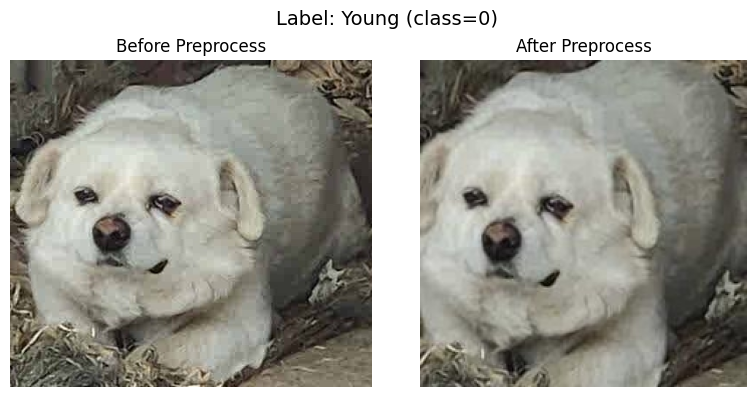

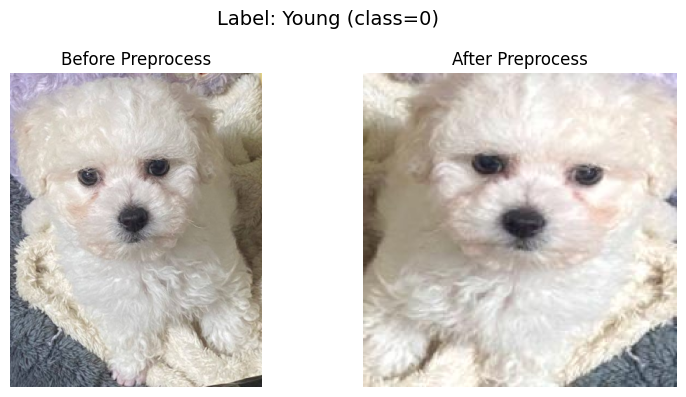

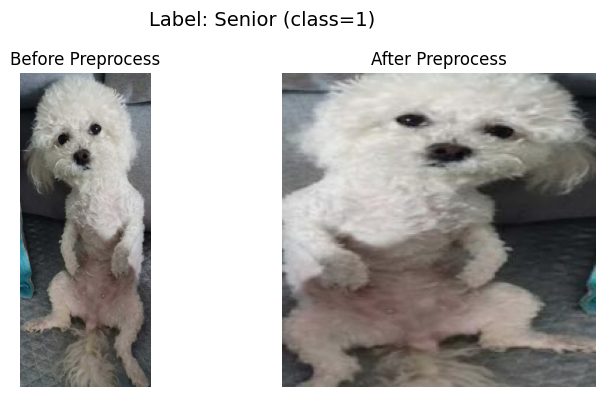

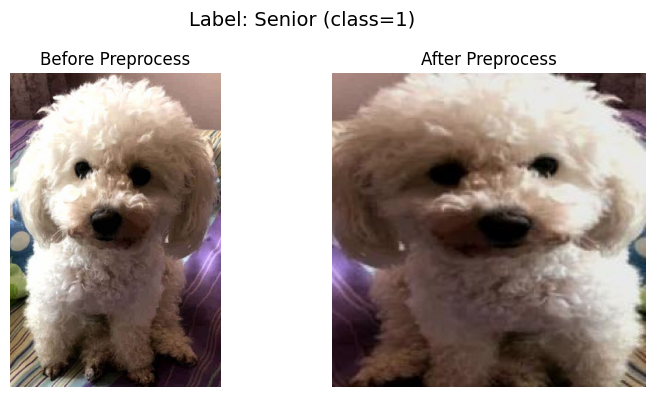

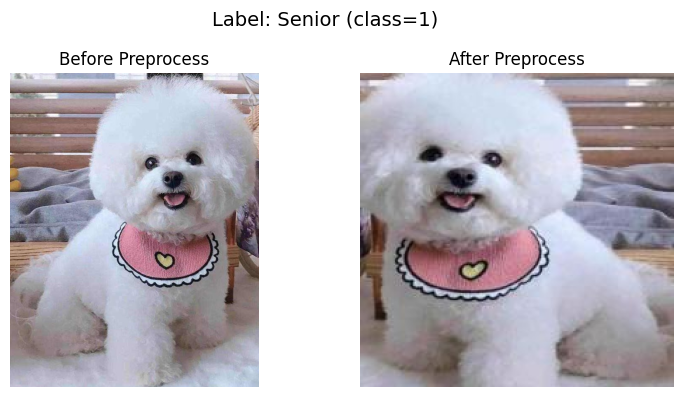

In [5]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision import transforms
from tqdm import tqdm

# 경로 설정
txt_path = 'AFAC/AFAC.txt'
raw_dir = 'AFAC/trainset'
pre_dir = 'AFAC/preprocessed'

# 텐서를 PIL로 변환
to_pil = ToPILImage()

# 라벨 매핑
label_map = {'Young': 0, 'Senior': 1}

# AFAC.txt에서 샘플 로드
samples = []
with open(txt_path, 'r') as f:
    for line in f:
        filename, label = line.strip().split('\t')
        samples.append((filename, label_map[label]))

# 시각화
for i in range(5):
    filename, label = samples[i]

    # 원본 이미지
    raw_img = Image.open(os.path.join(raw_dir, filename)).convert('RGB')

    # 전처리 이미지 (이미 Tensor로 저장된 건 아님)
    pre_img_path = os.path.join(pre_dir, filename.replace('.png', '.jpg'))
    pre_img = Image.open(pre_img_path).convert('RGB')

    # 시각화
    plt.figure(figsize=(8, 4))
    plt.suptitle(f"Label: {'Young' if label == 0 else 'Senior'} (class={label})", fontsize=14)

    plt.subplot(1, 2, 1)
    plt.imshow(raw_img)
    plt.title('Before Preprocess')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pre_img)
    plt.title('After Preprocess')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

✅ 총 로드된 샘플 수: 16920
⚠️ 누락된 이미지 파일 수: 1
예시 누락 파일명: ['O1CN01DYF38A20tSMfFRYma_!!6000000006907-0-antinsbiocamera.jpeg']


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


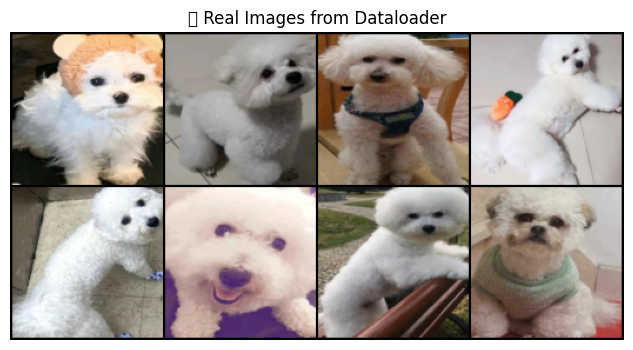

Labels: [0, 0, 1, 0, 0, 1, 0, 0]


In [10]:
# 화긴

# ------------------------------
# 1. 하이퍼파라미터 설정
# ------------------------------
batch_size = 64
# z_dim = 100              # ✅ 논문에 맞춰 축소
z_dim = 128
c_dim = 2
lr = 2e-4
num_epochs = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'

from torch.utils.data import DataLoader

# ------------------------------
# 2. Transform
# ------------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3)
])

# ------------------------------
# 3. 데이터셋 로드
# ------------------------------
dataset = AFACDataset("AFAC/AFAC.txt", "AFAC/preprocessed", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

import matplotlib.pyplot as plt
import torchvision.utils as vutils

# 배치 하나 받아오기
real_imgs, real_labels = next(iter(dataloader))

# 정규화 해제: [-1, 1] → [0, 1]
def denormalize(t):
    return t * 0.5 + 0.5

# 이미지 그리드로 만들고 시각화
grid = vutils.make_grid(denormalize(real_imgs[:8]), nrow=4)
plt.figure(figsize=(8, 4))
plt.imshow(grid.permute(1, 2, 0))  # (C, H, W) → (H, W, C)
plt.title("💡 Real Images from Dataloader")
plt.axis('off')
plt.show()

# 라벨도 함께 출력
print("Labels:", real_labels[:8].tolist())

In [8]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.utils import save_image  # 맨 위에 추가
from torch.optim.lr_scheduler import StepLR

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('ConvTranspose') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# ------------------------------
# 1. 하이퍼파라미터 설정
# ------------------------------
batch_size = 64
# z_dim = 100              # ✅ 논문에 맞춰 축소
z_dim = 128
c_dim = 2
lr = 2e-4
num_epochs = 300

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ------------------------------
# 2. Transform
# ------------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3)
])

# ------------------------------
# 3. 데이터셋 로드
# ------------------------------
dataset = AFACDataset("AFAC/AFAC.txt", "AFAC/preprocessed", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# ------------------------------
# 4. 모델 정의
# ------------------------------
# G = Generator(z_dim=z_dim, c_dim=c_dim).to(device)
G = InjectionGenerator(z_dim=z_dim, c_dim=c_dim).to(device)
# D = Discriminator(c_dim=c_dim).to(device)
D = ProjectionDiscriminator(c_dim=c_dim).to(device)


# ✅ Weight 초기화 (DCGAN 방식)
G.apply(weights_init)
D.apply(weights_init)

# ------------------------------
# 5. 손실 및 최적화
# ------------------------------
# bce_loss = nn.BCEWithLogitsLoss()   # ✅ Sigmoid 없이 사용
optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
scheduler_G = StepLR(optimizer_G, step_size=50, gamma=0.5)
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# ------------------------------
# 6. 유틸 함수
# ------------------------------        
# def generate_labels(size, value):
#     return torch.full((size, 1), value, dtype=torch.float, device=device)

def denormalize(t):
    return t * 0.5 + 0.5

def show_samples(generated_imgs, labels, title):
    grid = utils.make_grid(denormalize(generated_imgs[:8].cpu()), nrow=4)
    plt.figure(figsize=(8, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

# ------------------------------
# 7. 학습 루프
# ------------------------------
best_g_loss = float('inf')
z_fixed = torch.randn(20, z_dim, device=device)  # ✅ 고정 latent 벡터 # 수정

for epoch in range(num_epochs):
    G.train()
    D.train()
    epoch_start = time.time()
    loop = tqdm(dataloader, desc=f"[Epoch {epoch + 1}/{num_epochs}]", leave=False)

    for real_imgs, real_labels in loop:
        real_imgs = real_imgs.to(device)
        real_labels = real_labels.to(device)
        batch_size = real_imgs.size(0)

        z = torch.randn(batch_size, z_dim, device=device)

        # ▒ Train D ▒
        D.zero_grad()
        
        # (1) Real 이미지에 대한 loss
        real_out = D(real_imgs, real_labels)  # [B, 1]
        loss_D_real = torch.mean(F.relu(1.0 - real_out))  # hinge loss for real
        
        # (2) Fake 이미지 생성
        fake_labels = torch.randint(0, c_dim, (batch_size,), device=device)
        fake_cond = F.one_hot(fake_labels, num_classes=c_dim).float()
        fake_imgs = G(z, fake_cond)
        
        # (3) Fake 이미지에 대한 loss
        fake_out = D(fake_imgs.detach(), fake_labels)
        loss_D_fake = torch.mean(F.relu(1.0 + fake_out))  # hinge loss for fake
        
        d_loss = loss_D_real + loss_D_fake
        d_loss.backward()
        optimizer_D.step()
        
        # ▒ Train G ▒
        G.zero_grad()
        fake_imgs = G(z, fake_cond)
        fake_out = D(fake_imgs, fake_labels)
        
        g_loss = -torch.mean(fake_out)  # generator tries to increase D output
        
        g_loss.backward()
        optimizer_G.step()

        loop.set_postfix(d_loss=d_loss.item(), g_loss=g_loss.item())

    scheduler_G.step()  # 🔺 epoch 끝나고 한 번 호출 # 여기 추가!
    elapsed = time.time() - epoch_start
    print(f"✅ Epoch {epoch + 1:03d} 완료 | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f} | 소요시간: {elapsed / 60:.2f}분")

    # ------------------------------
    # 8. 매 N epoch마다 저장
    # ------------------------------
    save_every = 10  # 🔸10 epoch마다 저장
    version = "injected"  # 🔸 "injected"로 바꿔서 사용 가능
    
    ckpt_dir = os.path.join("checkpoints", version)
    sample_dir = os.path.join("samples", version)
    
    os.makedirs(ckpt_dir, exist_ok=True)
    os.makedirs(sample_dir, exist_ok=True)
    
    if (epoch + 1) % save_every == 0:
        # G weight 저장
        ckpt_path = os.path.join(ckpt_dir, f"G_epoch_{epoch+1:03d}.pth")
        checkpoint = {
            'epoch': epoch + 1,
            'G_state_dict': G.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'g_loss': g_loss.item(),
            'z_sample': z[:20].detach().cpu(),
            'c_sample': fake_labels[:20].detach().cpu()  # 조건을 fake_labels로 저장
        }
        torch.save(checkpoint, ckpt_path)
        
        # 이미지 저장
        img_path = os.path.join(sample_dir, f"sample_epoch_{epoch+1:03d}.png")
        
        with torch.no_grad():
            z_fixed = z_fixed  # 동일한 latent vector # 수정
    
            c_young = torch.zeros(20, dtype=torch.long, device=device)
            c_senior = torch.ones(20, dtype=torch.long, device=device)
    
            cond_young = F.one_hot(c_young, num_classes=c_dim).float()
            cond_senior = F.one_hot(c_senior, num_classes=c_dim).float()
    
            gen_young = G(z_fixed, cond_young)   # [20, 3, 128, 128]
            gen_senior = G(z_fixed, cond_senior) # [20, 3, 128, 128]
    
            interleaved = torch.stack([gen_young, gen_senior], dim=1)  # [20, 2, 3, 128, 128]
            sample_imgs = interleaved.flatten(0, 1)                    # [40, 3, 128, 128]
            save_image(denormalize(sample_imgs), img_path, nrow=10)

✅ 총 로드된 샘플 수: 16920
⚠️ 누락된 이미지 파일 수: 1
예시 누락 파일명: ['O1CN01DYF38A20tSMfFRYma_!!6000000006907-0-antinsbiocamera.jpeg']


✅ Epoch 001 완료 | D_loss: 1.8247 | G_loss: -0.1756 | 소요시간: 0.49분


✅ Epoch 002 완료 | D_loss: 1.6624 | G_loss: 0.9263 | 소요시간: 0.47분


✅ Epoch 003 완료 | D_loss: 1.7082 | G_loss: 0.4536 | 소요시간: 0.48분


✅ Epoch 004 완료 | D_loss: 1.3569 | G_loss: 0.6434 | 소요시간: 0.48분


✅ Epoch 005 완료 | D_loss: 0.7365 | G_loss: 0.9734 | 소요시간: 0.48분


✅ Epoch 006 완료 | D_loss: 1.1047 | G_loss: 0.9795 | 소요시간: 0.48분


✅ Epoch 007 완료 | D_loss: 1.6299 | G_loss: 0.8843 | 소요시간: 0.48분


✅ Epoch 008 완료 | D_loss: 0.9980 | G_loss: 0.8678 | 소요시간: 0.48분


✅ Epoch 009 완료 | D_loss: 0.7235 | G_loss: 0.9188 | 소요시간: 0.48분


✅ Epoch 010 완료 | D_loss: 1.1304 | G_loss: 1.0056 | 소요시간: 0.48분


✅ Epoch 011 완료 | D_loss: 1.4498 | G_loss: 0.9908 | 소요시간: 0.48분


✅ Epoch 012 완료 | D_loss: 1.3206 | G_loss: 0.6136 | 소요시간: 0.48분


✅ Epoch 013 완료 | D_loss: 1.3981 | G_loss: 0.9678 | 소요시간: 0.48분


✅ Epoch 014 완료 | D_loss: 1.0859 | G_loss: 0.8111 | 소요시간: 0.48분


✅ Epoch 015 완료 | D_loss: 1.1944 | G_loss: 1.1366 | 소요시간: 0.48분


✅ Epoch 016 완료 | D_loss: 1.6287 | G_loss: 0.9103 | 소요시간: 0.48분


✅ Epoch 017 완료 | D_loss: 1.1434 | G_loss: 0.6711 | 소요시간: 0.48분


✅ Epoch 018 완료 | D_loss: 1.5198 | G_loss: 0.9857 | 소요시간: 0.48분


✅ Epoch 019 완료 | D_loss: 1.2826 | G_loss: 1.0266 | 소요시간: 0.48분


✅ Epoch 020 완료 | D_loss: 0.6851 | G_loss: 1.1239 | 소요시간: 0.48분


✅ Epoch 021 완료 | D_loss: 1.0320 | G_loss: 0.9351 | 소요시간: 0.48분


✅ Epoch 022 완료 | D_loss: 1.1936 | G_loss: 1.1830 | 소요시간: 0.48분


✅ Epoch 023 완료 | D_loss: 1.5172 | G_loss: 0.9447 | 소요시간: 0.48분


✅ Epoch 024 완료 | D_loss: 1.0331 | G_loss: 1.1064 | 소요시간: 0.48분


✅ Epoch 025 완료 | D_loss: 1.6156 | G_loss: 0.6276 | 소요시간: 0.48분


✅ Epoch 026 완료 | D_loss: 1.2739 | G_loss: 0.8706 | 소요시간: 0.48분


✅ Epoch 027 완료 | D_loss: 1.3805 | G_loss: 1.0549 | 소요시간: 0.48분


✅ Epoch 028 완료 | D_loss: 0.9384 | G_loss: 1.3324 | 소요시간: 0.48분


✅ Epoch 029 완료 | D_loss: 1.2532 | G_loss: 1.1374 | 소요시간: 0.48분


✅ Epoch 030 완료 | D_loss: 1.7200 | G_loss: 1.0687 | 소요시간: 0.48분


✅ Epoch 031 완료 | D_loss: 1.3653 | G_loss: 1.1949 | 소요시간: 0.48분


✅ Epoch 032 완료 | D_loss: 1.4875 | G_loss: 1.0655 | 소요시간: 0.48분


✅ Epoch 033 완료 | D_loss: 1.2527 | G_loss: 1.0831 | 소요시간: 0.48분


✅ Epoch 034 완료 | D_loss: 1.2939 | G_loss: 0.8216 | 소요시간: 0.48분


✅ Epoch 035 완료 | D_loss: 1.4565 | G_loss: 0.8259 | 소요시간: 0.48분


✅ Epoch 036 완료 | D_loss: 1.3980 | G_loss: 0.6158 | 소요시간: 0.48분


✅ Epoch 037 완료 | D_loss: 1.1574 | G_loss: 0.9588 | 소요시간: 0.48분


✅ Epoch 038 완료 | D_loss: 1.0207 | G_loss: 0.9617 | 소요시간: 0.48분


✅ Epoch 039 완료 | D_loss: 1.2909 | G_loss: 1.2187 | 소요시간: 0.48분


✅ Epoch 040 완료 | D_loss: 1.1096 | G_loss: 0.9777 | 소요시간: 0.48분


✅ Epoch 041 완료 | D_loss: 1.6627 | G_loss: 1.3602 | 소요시간: 0.48분


✅ Epoch 042 완료 | D_loss: 1.3315 | G_loss: 0.9174 | 소요시간: 0.48분


✅ Epoch 043 완료 | D_loss: 1.4396 | G_loss: 0.8505 | 소요시간: 0.48분


✅ Epoch 044 완료 | D_loss: 1.4245 | G_loss: 0.7789 | 소요시간: 0.48분


✅ Epoch 045 완료 | D_loss: 1.4273 | G_loss: 0.7530 | 소요시간: 0.48분


✅ Epoch 046 완료 | D_loss: 1.4492 | G_loss: 0.5358 | 소요시간: 0.48분


✅ Epoch 047 완료 | D_loss: 1.1707 | G_loss: 1.3795 | 소요시간: 0.48분


✅ Epoch 048 완료 | D_loss: 1.3779 | G_loss: 1.2665 | 소요시간: 0.48분


✅ Epoch 049 완료 | D_loss: 0.9233 | G_loss: 0.8457 | 소요시간: 0.48분


✅ Epoch 050 완료 | D_loss: 1.0849 | G_loss: 1.1637 | 소요시간: 0.48분


✅ Epoch 051 완료 | D_loss: 1.0528 | G_loss: 0.8077 | 소요시간: 0.48분


✅ Epoch 052 완료 | D_loss: 1.1342 | G_loss: 0.6353 | 소요시간: 0.48분


✅ Epoch 053 완료 | D_loss: 1.3464 | G_loss: 0.9943 | 소요시간: 0.48분


✅ Epoch 054 완료 | D_loss: 1.2755 | G_loss: 1.2969 | 소요시간: 0.48분


✅ Epoch 055 완료 | D_loss: 1.5888 | G_loss: 1.6430 | 소요시간: 0.48분


✅ Epoch 056 완료 | D_loss: 0.8847 | G_loss: 1.1810 | 소요시간: 0.48분


✅ Epoch 057 완료 | D_loss: 1.1280 | G_loss: 0.9631 | 소요시간: 0.48분


✅ Epoch 058 완료 | D_loss: 0.9121 | G_loss: 1.4745 | 소요시간: 0.48분


✅ Epoch 059 완료 | D_loss: 1.0555 | G_loss: 0.5209 | 소요시간: 0.48분


✅ Epoch 060 완료 | D_loss: 1.1867 | G_loss: 1.1273 | 소요시간: 0.48분


✅ Epoch 061 완료 | D_loss: 0.9870 | G_loss: 2.0762 | 소요시간: 0.48분


✅ Epoch 062 완료 | D_loss: 0.9447 | G_loss: 1.5123 | 소요시간: 0.48분


✅ Epoch 063 완료 | D_loss: 0.6875 | G_loss: 1.0739 | 소요시간: 0.48분


✅ Epoch 064 완료 | D_loss: 0.9265 | G_loss: 2.1281 | 소요시간: 0.48분


✅ Epoch 065 완료 | D_loss: 1.0543 | G_loss: 1.1993 | 소요시간: 0.48분


✅ Epoch 066 완료 | D_loss: 0.9701 | G_loss: 1.1223 | 소요시간: 0.48분


✅ Epoch 067 완료 | D_loss: 0.7899 | G_loss: 1.3205 | 소요시간: 0.48분


✅ Epoch 068 완료 | D_loss: 0.9949 | G_loss: 1.1051 | 소요시간: 0.48분


✅ Epoch 069 완료 | D_loss: 0.9534 | G_loss: 1.5092 | 소요시간: 0.47분


✅ Epoch 070 완료 | D_loss: 0.9613 | G_loss: 0.9457 | 소요시간: 0.47분


✅ Epoch 071 완료 | D_loss: 1.0906 | G_loss: 1.1906 | 소요시간: 0.48분


✅ Epoch 072 완료 | D_loss: 1.0013 | G_loss: 1.4129 | 소요시간: 0.48분


✅ Epoch 073 완료 | D_loss: 1.0498 | G_loss: 0.5773 | 소요시간: 0.48분


✅ Epoch 074 완료 | D_loss: 0.8733 | G_loss: 0.9305 | 소요시간: 0.48분


✅ Epoch 075 완료 | D_loss: 0.9249 | G_loss: 1.8257 | 소요시간: 0.48분


✅ Epoch 076 완료 | D_loss: 0.6362 | G_loss: 1.9214 | 소요시간: 0.48분


✅ Epoch 077 완료 | D_loss: 1.1227 | G_loss: 1.3993 | 소요시간: 0.48분


✅ Epoch 078 완료 | D_loss: 0.8605 | G_loss: 1.1685 | 소요시간: 0.48분


✅ Epoch 079 완료 | D_loss: 0.6832 | G_loss: 1.0332 | 소요시간: 0.48분


✅ Epoch 080 완료 | D_loss: 1.0194 | G_loss: -0.0327 | 소요시간: 0.48분


✅ Epoch 081 완료 | D_loss: 0.5932 | G_loss: 1.3140 | 소요시간: 0.48분


✅ Epoch 082 완료 | D_loss: 0.8286 | G_loss: 1.5847 | 소요시간: 0.48분


✅ Epoch 083 완료 | D_loss: 0.7318 | G_loss: 0.8045 | 소요시간: 0.48분


✅ Epoch 084 완료 | D_loss: 0.5290 | G_loss: 1.9484 | 소요시간: 0.48분


✅ Epoch 085 완료 | D_loss: 0.6436 | G_loss: 1.0552 | 소요시간: 0.48분


✅ Epoch 086 완료 | D_loss: 1.1523 | G_loss: 1.7783 | 소요시간: 0.48분


✅ Epoch 087 완료 | D_loss: 0.9847 | G_loss: 1.5601 | 소요시간: 0.48분


✅ Epoch 088 완료 | D_loss: 0.8336 | G_loss: 0.8517 | 소요시간: 0.48분


✅ Epoch 089 완료 | D_loss: 0.8312 | G_loss: 1.2278 | 소요시간: 0.48분


✅ Epoch 090 완료 | D_loss: 0.6262 | G_loss: 1.6679 | 소요시간: 0.48분


✅ Epoch 091 완료 | D_loss: 0.5441 | G_loss: 1.8696 | 소요시간: 0.48분


✅ Epoch 092 완료 | D_loss: 0.5395 | G_loss: 2.2459 | 소요시간: 0.48분


✅ Epoch 093 완료 | D_loss: 1.0346 | G_loss: 1.1975 | 소요시간: 0.48분


✅ Epoch 094 완료 | D_loss: 0.9003 | G_loss: 1.7806 | 소요시간: 0.48분


✅ Epoch 095 완료 | D_loss: 0.9120 | G_loss: 1.8932 | 소요시간: 0.48분


✅ Epoch 096 완료 | D_loss: 0.8834 | G_loss: 2.7414 | 소요시간: 0.48분


✅ Epoch 097 완료 | D_loss: 0.6476 | G_loss: 1.3924 | 소요시간: 0.48분


✅ Epoch 098 완료 | D_loss: 0.6856 | G_loss: 1.1268 | 소요시간: 0.48분


✅ Epoch 099 완료 | D_loss: 0.8001 | G_loss: 1.6874 | 소요시간: 0.48분


✅ Epoch 100 완료 | D_loss: 0.5348 | G_loss: 1.6459 | 소요시간: 0.48분


✅ Epoch 101 완료 | D_loss: 0.4436 | G_loss: 1.8362 | 소요시간: 0.48분


✅ Epoch 102 완료 | D_loss: 0.4015 | G_loss: 1.7819 | 소요시간: 0.48분


✅ Epoch 103 완료 | D_loss: 0.3856 | G_loss: 1.9333 | 소요시간: 0.48분


✅ Epoch 104 완료 | D_loss: 0.7104 | G_loss: 2.0000 | 소요시간: 0.48분


✅ Epoch 105 완료 | D_loss: 0.8900 | G_loss: 1.1508 | 소요시간: 0.48분


✅ Epoch 106 완료 | D_loss: 0.5229 | G_loss: 2.0642 | 소요시간: 0.48분


✅ Epoch 107 완료 | D_loss: 0.5069 | G_loss: 0.9779 | 소요시간: 0.48분


✅ Epoch 108 완료 | D_loss: 0.8850 | G_loss: 1.4227 | 소요시간: 0.48분


✅ Epoch 109 완료 | D_loss: 0.3727 | G_loss: 1.5954 | 소요시간: 0.47분


✅ Epoch 110 완료 | D_loss: 0.4008 | G_loss: 0.7697 | 소요시간: 0.48분


✅ Epoch 111 완료 | D_loss: 0.5676 | G_loss: 0.4549 | 소요시간: 0.48분


✅ Epoch 112 완료 | D_loss: 0.3062 | G_loss: 1.4271 | 소요시간: 0.48분


✅ Epoch 113 완료 | D_loss: 0.2531 | G_loss: 1.7971 | 소요시간: 0.48분


✅ Epoch 114 완료 | D_loss: 0.3245 | G_loss: 2.0952 | 소요시간: 0.48분


✅ Epoch 115 완료 | D_loss: 0.5376 | G_loss: 1.1772 | 소요시간: 0.48분


✅ Epoch 116 완료 | D_loss: 0.3661 | G_loss: 2.0162 | 소요시간: 0.48분


✅ Epoch 117 완료 | D_loss: 0.5684 | G_loss: 2.5926 | 소요시간: 0.48분


✅ Epoch 118 완료 | D_loss: 0.3083 | G_loss: 1.7366 | 소요시간: 0.48분


✅ Epoch 119 완료 | D_loss: 0.5843 | G_loss: 2.6032 | 소요시간: 0.48분


✅ Epoch 120 완료 | D_loss: 0.5500 | G_loss: 1.7046 | 소요시간: 0.48분


✅ Epoch 121 완료 | D_loss: 0.4121 | G_loss: 2.5862 | 소요시간: 0.48분


✅ Epoch 122 완료 | D_loss: 0.1617 | G_loss: 1.9560 | 소요시간: 0.48분


✅ Epoch 123 완료 | D_loss: 0.3596 | G_loss: 2.5479 | 소요시간: 0.48분


✅ Epoch 124 완료 | D_loss: 0.3900 | G_loss: 1.7813 | 소요시간: 0.48분


✅ Epoch 125 완료 | D_loss: 0.5952 | G_loss: 1.1083 | 소요시간: 0.48분


✅ Epoch 126 완료 | D_loss: 0.5945 | G_loss: 2.2356 | 소요시간: 0.48분


✅ Epoch 127 완료 | D_loss: 0.1900 | G_loss: 1.6152 | 소요시간: 0.48분


✅ Epoch 128 완료 | D_loss: 0.5621 | G_loss: 2.2338 | 소요시간: 0.48분


✅ Epoch 129 완료 | D_loss: 0.1995 | G_loss: 2.0148 | 소요시간: 0.48분


✅ Epoch 130 완료 | D_loss: 0.2600 | G_loss: 1.3748 | 소요시간: 0.48분


✅ Epoch 131 완료 | D_loss: 0.1998 | G_loss: 2.0280 | 소요시간: 0.48분


✅ Epoch 132 완료 | D_loss: 0.3309 | G_loss: 2.4642 | 소요시간: 0.48분


✅ Epoch 133 완료 | D_loss: 0.5075 | G_loss: 1.2077 | 소요시간: 0.48분


✅ Epoch 134 완료 | D_loss: 0.2653 | G_loss: 2.1557 | 소요시간: 0.48분


✅ Epoch 135 완료 | D_loss: 0.3044 | G_loss: 2.5100 | 소요시간: 0.47분


✅ Epoch 136 완료 | D_loss: 0.2359 | G_loss: 1.9511 | 소요시간: 0.47분


✅ Epoch 137 완료 | D_loss: 0.1300 | G_loss: 2.0148 | 소요시간: 0.48분


✅ Epoch 138 완료 | D_loss: 0.2039 | G_loss: 2.7439 | 소요시간: 0.47분


✅ Epoch 139 완료 | D_loss: 0.3558 | G_loss: 1.3173 | 소요시간: 0.47분


✅ Epoch 140 완료 | D_loss: 0.2911 | G_loss: 2.2178 | 소요시간: 0.47분


✅ Epoch 141 완료 | D_loss: 0.3224 | G_loss: 2.3096 | 소요시간: 0.48분


✅ Epoch 142 완료 | D_loss: 0.0885 | G_loss: 2.3634 | 소요시간: 0.47분


✅ Epoch 143 완료 | D_loss: 0.3294 | G_loss: 1.6360 | 소요시간: 0.47분


✅ Epoch 144 완료 | D_loss: 0.4701 | G_loss: 0.7866 | 소요시간: 0.47분


✅ Epoch 145 완료 | D_loss: 0.2946 | G_loss: 2.0995 | 소요시간: 0.48분


✅ Epoch 146 완료 | D_loss: 0.1804 | G_loss: 2.3155 | 소요시간: 0.47분


✅ Epoch 147 완료 | D_loss: 0.1786 | G_loss: 2.3558 | 소요시간: 0.48분


✅ Epoch 148 완료 | D_loss: 0.3720 | G_loss: 1.5991 | 소요시간: 0.47분


✅ Epoch 149 완료 | D_loss: 0.2677 | G_loss: 1.8417 | 소요시간: 0.48분


✅ Epoch 150 완료 | D_loss: 0.1350 | G_loss: 1.8511 | 소요시간: 0.48분


✅ Epoch 151 완료 | D_loss: 0.2224 | G_loss: 2.1896 | 소요시간: 0.48분


✅ Epoch 152 완료 | D_loss: 0.2143 | G_loss: 2.6217 | 소요시간: 0.48분


✅ Epoch 153 완료 | D_loss: 0.2819 | G_loss: 2.8333 | 소요시간: 0.48분


✅ Epoch 154 완료 | D_loss: 0.2745 | G_loss: 2.6710 | 소요시간: 0.48분


✅ Epoch 155 완료 | D_loss: 0.1247 | G_loss: 1.4617 | 소요시간: 0.48분


✅ Epoch 156 완료 | D_loss: 0.1242 | G_loss: 2.0578 | 소요시간: 0.47분


✅ Epoch 157 완료 | D_loss: 0.0792 | G_loss: 1.6587 | 소요시간: 0.48분


✅ Epoch 158 완료 | D_loss: 0.2076 | G_loss: 2.0320 | 소요시간: 0.48분


✅ Epoch 159 완료 | D_loss: 0.2482 | G_loss: 2.1033 | 소요시간: 0.47분


✅ Epoch 160 완료 | D_loss: 0.3034 | G_loss: 3.0000 | 소요시간: 0.47분


✅ Epoch 161 완료 | D_loss: 0.2330 | G_loss: 2.4406 | 소요시간: 0.48분


✅ Epoch 162 완료 | D_loss: 0.1709 | G_loss: 1.6907 | 소요시간: 0.48분


✅ Epoch 163 완료 | D_loss: 0.0742 | G_loss: 2.3594 | 소요시간: 0.48분


✅ Epoch 164 완료 | D_loss: 0.1841 | G_loss: 2.4244 | 소요시간: 0.48분


✅ Epoch 165 완료 | D_loss: 0.2947 | G_loss: 2.0873 | 소요시간: 0.48분


✅ Epoch 166 완료 | D_loss: 0.1953 | G_loss: 2.1668 | 소요시간: 0.47분


✅ Epoch 167 완료 | D_loss: 0.3429 | G_loss: 0.8039 | 소요시간: 0.48분


✅ Epoch 168 완료 | D_loss: 0.1066 | G_loss: 1.8371 | 소요시간: 0.48분


✅ Epoch 169 완료 | D_loss: 0.0980 | G_loss: 2.4746 | 소요시간: 0.48분


✅ Epoch 170 완료 | D_loss: 0.1922 | G_loss: 1.9513 | 소요시간: 0.47분


✅ Epoch 171 완료 | D_loss: 0.2910 | G_loss: 2.4466 | 소요시간: 0.48분


✅ Epoch 172 완료 | D_loss: 0.3069 | G_loss: 1.7833 | 소요시간: 0.48분


✅ Epoch 173 완료 | D_loss: 0.1033 | G_loss: 2.2898 | 소요시간: 0.48분


✅ Epoch 174 완료 | D_loss: 0.2092 | G_loss: 1.2772 | 소요시간: 0.48분


✅ Epoch 175 완료 | D_loss: 0.0872 | G_loss: 2.2668 | 소요시간: 0.48분


✅ Epoch 176 완료 | D_loss: 0.1713 | G_loss: 2.6803 | 소요시간: 0.47분


✅ Epoch 177 완료 | D_loss: 0.2631 | G_loss: 0.9043 | 소요시간: 0.48분


✅ Epoch 178 완료 | D_loss: 0.1360 | G_loss: 1.5288 | 소요시간: 0.47분


✅ Epoch 179 완료 | D_loss: 0.0950 | G_loss: 2.1768 | 소요시간: 0.47분


✅ Epoch 180 완료 | D_loss: 0.0230 | G_loss: 2.2985 | 소요시간: 0.48분


✅ Epoch 181 완료 | D_loss: 0.1230 | G_loss: 1.4420 | 소요시간: 0.48분


✅ Epoch 182 완료 | D_loss: 0.1781 | G_loss: 1.5464 | 소요시간: 0.48분


✅ Epoch 183 완료 | D_loss: 0.1168 | G_loss: 2.2640 | 소요시간: 0.48분


✅ Epoch 184 완료 | D_loss: 0.1574 | G_loss: 1.5273 | 소요시간: 0.47분


✅ Epoch 185 완료 | D_loss: 0.0242 | G_loss: 1.5847 | 소요시간: 0.48분


✅ Epoch 186 완료 | D_loss: 0.2816 | G_loss: 3.0116 | 소요시간: 0.48분


✅ Epoch 187 완료 | D_loss: 0.1397 | G_loss: 2.3210 | 소요시간: 0.48분


✅ Epoch 188 완료 | D_loss: 0.1274 | G_loss: 2.5694 | 소요시간: 0.48분


✅ Epoch 189 완료 | D_loss: 0.1317 | G_loss: 1.6302 | 소요시간: 0.48분


✅ Epoch 190 완료 | D_loss: 0.1258 | G_loss: 1.9078 | 소요시간: 0.48분


✅ Epoch 191 완료 | D_loss: 0.0760 | G_loss: 2.3930 | 소요시간: 0.48분


✅ Epoch 192 완료 | D_loss: 0.0849 | G_loss: 2.0811 | 소요시간: 0.48분


✅ Epoch 193 완료 | D_loss: 0.0975 | G_loss: 1.5291 | 소요시간: 0.48분


✅ Epoch 194 완료 | D_loss: 0.1489 | G_loss: 2.4507 | 소요시간: 0.47분


✅ Epoch 195 완료 | D_loss: 0.1623 | G_loss: 1.8355 | 소요시간: 0.48분


✅ Epoch 196 완료 | D_loss: 0.0813 | G_loss: 2.1829 | 소요시간: 0.48분


✅ Epoch 197 완료 | D_loss: 0.2415 | G_loss: 1.1949 | 소요시간: 0.48분


✅ Epoch 198 완료 | D_loss: 0.1056 | G_loss: 1.6668 | 소요시간: 0.48분


✅ Epoch 199 완료 | D_loss: 0.1734 | G_loss: 2.7927 | 소요시간: 0.47분


✅ Epoch 200 완료 | D_loss: 0.2121 | G_loss: 1.9167 | 소요시간: 0.48분


✅ Epoch 201 완료 | D_loss: 0.0131 | G_loss: 2.1729 | 소요시간: 0.48분


✅ Epoch 202 완료 | D_loss: 0.0794 | G_loss: 2.4574 | 소요시간: 0.48분


✅ Epoch 203 완료 | D_loss: 0.0946 | G_loss: 1.9836 | 소요시간: 0.48분


✅ Epoch 204 완료 | D_loss: 0.0736 | G_loss: 2.1675 | 소요시간: 0.47분


✅ Epoch 205 완료 | D_loss: 0.0617 | G_loss: 1.9698 | 소요시간: 0.48분


✅ Epoch 206 완료 | D_loss: 0.0535 | G_loss: 1.4341 | 소요시간: 0.48분


✅ Epoch 207 완료 | D_loss: 0.0347 | G_loss: 2.2685 | 소요시간: 0.47분


✅ Epoch 208 완료 | D_loss: 0.0895 | G_loss: 1.9729 | 소요시간: 0.48분


✅ Epoch 209 완료 | D_loss: 0.1068 | G_loss: 2.4839 | 소요시간: 0.48분


✅ Epoch 210 완료 | D_loss: 0.0558 | G_loss: 1.9396 | 소요시간: 0.47분


✅ Epoch 211 완료 | D_loss: 0.0710 | G_loss: 2.3320 | 소요시간: 0.48분


✅ Epoch 212 완료 | D_loss: 0.0678 | G_loss: 2.5795 | 소요시간: 0.48분


✅ Epoch 213 완료 | D_loss: 0.1284 | G_loss: 2.4493 | 소요시간: 0.48분


✅ Epoch 214 완료 | D_loss: 0.2693 | G_loss: 2.6301 | 소요시간: 0.47분


✅ Epoch 215 완료 | D_loss: 0.1414 | G_loss: 2.0778 | 소요시간: 0.47분


✅ Epoch 216 완료 | D_loss: 0.0672 | G_loss: 2.4499 | 소요시간: 0.48분


✅ Epoch 217 완료 | D_loss: 0.3052 | G_loss: 2.1781 | 소요시간: 0.47분


✅ Epoch 218 완료 | D_loss: 0.1361 | G_loss: 1.7340 | 소요시간: 0.47분


✅ Epoch 219 완료 | D_loss: 0.0478 | G_loss: 2.9058 | 소요시간: 0.48분


✅ Epoch 220 완료 | D_loss: 0.1353 | G_loss: 2.7560 | 소요시간: 0.47분


✅ Epoch 221 완료 | D_loss: 0.0151 | G_loss: 1.5067 | 소요시간: 0.48분


✅ Epoch 222 완료 | D_loss: 0.0958 | G_loss: 2.4603 | 소요시간: 0.48분


✅ Epoch 223 완료 | D_loss: 0.0775 | G_loss: 1.8251 | 소요시간: 0.47분


✅ Epoch 224 완료 | D_loss: 0.0219 | G_loss: 1.9846 | 소요시간: 0.48분


✅ Epoch 225 완료 | D_loss: 0.0902 | G_loss: 2.5160 | 소요시간: 0.48분


✅ Epoch 226 완료 | D_loss: 0.0519 | G_loss: 2.0634 | 소요시간: 0.48분


✅ Epoch 227 완료 | D_loss: 0.1185 | G_loss: 2.0897 | 소요시간: 0.48분


✅ Epoch 228 완료 | D_loss: 0.1443 | G_loss: 1.9690 | 소요시간: 0.48분


✅ Epoch 229 완료 | D_loss: 0.0239 | G_loss: 2.5923 | 소요시간: 0.47분


✅ Epoch 230 완료 | D_loss: 0.0280 | G_loss: 1.9842 | 소요시간: 0.48분


✅ Epoch 231 완료 | D_loss: 0.1176 | G_loss: 2.0402 | 소요시간: 0.48분


✅ Epoch 232 완료 | D_loss: 0.0556 | G_loss: 2.5122 | 소요시간: 0.48분


✅ Epoch 233 완료 | D_loss: 0.0544 | G_loss: 2.2171 | 소요시간: 0.47분


✅ Epoch 234 완료 | D_loss: 0.1016 | G_loss: 2.3157 | 소요시간: 0.48분


✅ Epoch 235 완료 | D_loss: 0.1409 | G_loss: 1.9893 | 소요시간: 0.47분


✅ Epoch 236 완료 | D_loss: 0.0372 | G_loss: 2.5183 | 소요시간: 0.48분


✅ Epoch 237 완료 | D_loss: 0.0289 | G_loss: 2.3066 | 소요시간: 0.47분


✅ Epoch 238 완료 | D_loss: 0.1078 | G_loss: 1.8366 | 소요시간: 0.48분


✅ Epoch 239 완료 | D_loss: 0.0581 | G_loss: 2.4178 | 소요시간: 0.47분


✅ Epoch 240 완료 | D_loss: 0.0443 | G_loss: 1.8831 | 소요시간: 0.47분


✅ Epoch 241 완료 | D_loss: 0.0423 | G_loss: 2.1933 | 소요시간: 0.48분


✅ Epoch 242 완료 | D_loss: 0.0751 | G_loss: 1.5881 | 소요시간: 0.48분


✅ Epoch 243 완료 | D_loss: 0.0584 | G_loss: 1.5315 | 소요시간: 0.48분


✅ Epoch 244 완료 | D_loss: 0.0309 | G_loss: 2.1743 | 소요시간: 0.48분


✅ Epoch 245 완료 | D_loss: 0.0997 | G_loss: 1.6862 | 소요시간: 0.48분


✅ Epoch 246 완료 | D_loss: 0.0008 | G_loss: 2.1095 | 소요시간: 0.47분


✅ Epoch 247 완료 | D_loss: 0.0384 | G_loss: 2.7816 | 소요시간: 0.48분


✅ Epoch 248 완료 | D_loss: 0.0575 | G_loss: 2.3457 | 소요시간: 0.48분


✅ Epoch 249 완료 | D_loss: 0.0577 | G_loss: 2.6537 | 소요시간: 0.48분


✅ Epoch 250 완료 | D_loss: 0.0204 | G_loss: 2.0088 | 소요시간: 0.48분


✅ Epoch 251 완료 | D_loss: 0.0863 | G_loss: 1.3439 | 소요시간: 0.48분


✅ Epoch 252 완료 | D_loss: 0.1167 | G_loss: 2.0838 | 소요시간: 0.48분


✅ Epoch 253 완료 | D_loss: 0.1308 | G_loss: 2.1408 | 소요시간: 0.48분


✅ Epoch 254 완료 | D_loss: 0.0204 | G_loss: 2.0899 | 소요시간: 0.47분


✅ Epoch 255 완료 | D_loss: 0.0914 | G_loss: 1.9897 | 소요시간: 0.47분


✅ Epoch 256 완료 | D_loss: 0.0756 | G_loss: 3.0881 | 소요시간: 0.48분


✅ Epoch 257 완료 | D_loss: 0.0444 | G_loss: 1.7451 | 소요시간: 0.48분


✅ Epoch 258 완료 | D_loss: 0.0613 | G_loss: 2.7230 | 소요시간: 0.47분


✅ Epoch 259 완료 | D_loss: 0.0348 | G_loss: 2.1312 | 소요시간: 0.47분


✅ Epoch 260 완료 | D_loss: 0.1074 | G_loss: 3.0859 | 소요시간: 0.48분


✅ Epoch 261 완료 | D_loss: 0.0153 | G_loss: 2.5342 | 소요시간: 0.48분


✅ Epoch 262 완료 | D_loss: 0.0484 | G_loss: 2.7970 | 소요시간: 0.48분


✅ Epoch 263 완료 | D_loss: 0.1033 | G_loss: 1.9719 | 소요시간: 0.47분


✅ Epoch 264 완료 | D_loss: 0.0898 | G_loss: 2.1801 | 소요시간: 0.48분


✅ Epoch 265 완료 | D_loss: 0.0000 | G_loss: 2.1735 | 소요시간: 0.47분


✅ Epoch 266 완료 | D_loss: 0.2096 | G_loss: 2.8361 | 소요시간: 0.47분


✅ Epoch 267 완료 | D_loss: 0.0281 | G_loss: 2.9502 | 소요시간: 0.48분


✅ Epoch 268 완료 | D_loss: 0.0209 | G_loss: 2.0849 | 소요시간: 0.48분


✅ Epoch 269 완료 | D_loss: 0.0896 | G_loss: 2.3821 | 소요시간: 0.47분


✅ Epoch 270 완료 | D_loss: 0.0542 | G_loss: 2.2482 | 소요시간: 0.48분


✅ Epoch 271 완료 | D_loss: 0.0483 | G_loss: 2.2476 | 소요시간: 0.48분


✅ Epoch 272 완료 | D_loss: 0.0522 | G_loss: 2.4141 | 소요시간: 0.47분


✅ Epoch 273 완료 | D_loss: 0.0660 | G_loss: 2.2428 | 소요시간: 0.48분


✅ Epoch 274 완료 | D_loss: 0.0462 | G_loss: 2.8965 | 소요시간: 0.47분


✅ Epoch 275 완료 | D_loss: 0.1167 | G_loss: 2.8628 | 소요시간: 0.48분


✅ Epoch 276 완료 | D_loss: 0.0857 | G_loss: 2.6339 | 소요시간: 0.48분


✅ Epoch 277 완료 | D_loss: 0.1639 | G_loss: 1.7428 | 소요시간: 0.48분


✅ Epoch 278 완료 | D_loss: 0.0402 | G_loss: 1.9369 | 소요시간: 0.47분


✅ Epoch 279 완료 | D_loss: 0.0072 | G_loss: 2.1776 | 소요시간: 0.48분


✅ Epoch 280 완료 | D_loss: 0.0346 | G_loss: 1.9355 | 소요시간: 0.48분


✅ Epoch 281 완료 | D_loss: 0.0747 | G_loss: 1.9661 | 소요시간: 0.48분


✅ Epoch 282 완료 | D_loss: 0.0454 | G_loss: 2.4454 | 소요시간: 0.48분


✅ Epoch 283 완료 | D_loss: 0.0700 | G_loss: 2.0751 | 소요시간: 0.48분


✅ Epoch 284 완료 | D_loss: 0.0237 | G_loss: 1.8704 | 소요시간: 0.47분


✅ Epoch 285 완료 | D_loss: 0.0197 | G_loss: 1.9768 | 소요시간: 0.47분


✅ Epoch 286 완료 | D_loss: 0.0354 | G_loss: 2.4697 | 소요시간: 0.47분


✅ Epoch 287 완료 | D_loss: 0.0322 | G_loss: 2.8582 | 소요시간: 0.47분


✅ Epoch 288 완료 | D_loss: 0.1366 | G_loss: 1.7191 | 소요시간: 0.47분


✅ Epoch 289 완료 | D_loss: 0.0504 | G_loss: 2.3164 | 소요시간: 0.47분


✅ Epoch 290 완료 | D_loss: 0.0289 | G_loss: 2.4869 | 소요시간: 0.47분


✅ Epoch 291 완료 | D_loss: 0.0532 | G_loss: 2.0892 | 소요시간: 0.48분


✅ Epoch 292 완료 | D_loss: 0.0449 | G_loss: 2.6852 | 소요시간: 0.48분


✅ Epoch 293 완료 | D_loss: 0.0394 | G_loss: 2.6659 | 소요시간: 0.47분


✅ Epoch 294 완료 | D_loss: 0.0168 | G_loss: 2.3564 | 소요시간: 0.48분


✅ Epoch 295 완료 | D_loss: 0.0888 | G_loss: 2.4503 | 소요시간: 0.47분


✅ Epoch 296 완료 | D_loss: 0.0373 | G_loss: 2.0817 | 소요시간: 0.48분


✅ Epoch 297 완료 | D_loss: 0.0173 | G_loss: 2.6011 | 소요시간: 0.47분


✅ Epoch 298 완료 | D_loss: 0.0232 | G_loss: 2.4726 | 소요시간: 0.48분


✅ Epoch 299 완료 | D_loss: 0.0117 | G_loss: 2.3483 | 소요시간: 0.47분


✅ Epoch 300 완료 | D_loss: 0.0722 | G_loss: 2.6211 | 소요시간: 0.48분


In [25]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

# ------------------------------
# 1. 하이퍼파라미터 설정
# ------------------------------
batch_size = 64
z_dim = 128
c_dim = 2
lr = 2e-4
num_epochs = 300
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ------------------------------
# 2. Transform
# ------------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3)
])

# ------------------------------
# 3. 데이터셋 로드
# ------------------------------
dataset = AFACDataset("AFAC/AFAC.txt", "AFAC/preprocessed", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# ------------------------------
# 4. 모델 정의 (✅ 새로운 버전 사용)
# ------------------------------
G = ConcatGenerator(z_dim=z_dim, c_dim=c_dim, c_emb_dim=16).to(device)
D = ConcatDiscriminator(c_dim=c_dim, embed_dim=16).to(device)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('ConvTranspose') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G.apply(weights_init)
D.apply(weights_init)

# ------------------------------
# 5. 손실 및 최적화
# ------------------------------
optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
scheduler_G = StepLR(optimizer_G, step_size=50, gamma=0.5)
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# ------------------------------
# 6. 유틸 함수
# ------------------------------
def denormalize(t):
    return t * 0.5 + 0.5

# ------------------------------
# 7. 학습 루프
# ------------------------------
best_g_loss = float('inf')
z_fixed = torch.randn(20, z_dim, device=device)

for epoch in range(num_epochs):
    G.train()
    D.train()
    epoch_start = time.time()
    loop = tqdm(dataloader, desc=f"[Epoch {epoch + 1}/{num_epochs}]", leave=False)

    for real_imgs, real_labels in loop:
        real_imgs = real_imgs.to(device)
        real_labels = real_labels.to(device)
        batch_size = real_imgs.size(0)

        z = torch.randn(batch_size, z_dim, device=device)

        # ▒ Train D ▒
        D.zero_grad()
        real_out = D(real_imgs, F.one_hot(real_labels, num_classes=c_dim).float())
        loss_D_real = torch.mean(F.relu(1.0 - real_out))

        fake_labels = torch.randint(0, c_dim, (batch_size,), device=device)
        fake_cond = F.one_hot(fake_labels, num_classes=c_dim).float()
        fake_imgs = G(z, fake_cond)

        fake_out = D(fake_imgs.detach(), fake_cond)
        loss_D_fake = torch.mean(F.relu(1.0 + fake_out))

        d_loss = loss_D_real + loss_D_fake
        d_loss.backward()
        optimizer_D.step()

        # ▒ Train G ▒
        G.zero_grad()
        fake_imgs = G(z, fake_cond)
        fake_out = D(fake_imgs, fake_cond)
        g_loss = -torch.mean(fake_out)

        g_loss.backward()
        optimizer_G.step()

        loop.set_postfix(d_loss=d_loss.item(), g_loss=g_loss.item())

    scheduler_G.step()
    elapsed = time.time() - epoch_start
    print(f"✅ Epoch {epoch + 1:03d} 완료 | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f} | 소요시간: {elapsed / 60:.2f}분")

    # ------------------------------
    # 8. 매 N epoch마다 저장
    # ------------------------------
    save_every = 10
    version = "concat"  # ✅ 이전 버전과 절대 겹치지 않도록
    ckpt_dir = os.path.join("checkpoints", version)
    sample_dir = os.path.join("samples", version)
    os.makedirs(ckpt_dir, exist_ok=True)
    os.makedirs(sample_dir, exist_ok=True)

    if (epoch + 1) % save_every == 0:
        ckpt_path = os.path.join(ckpt_dir, f"G_epoch_{epoch+1:03d}.pth")
        checkpoint = {
            'epoch': epoch + 1,
            'G_state_dict': G.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'g_loss': g_loss.item(),
            'z_sample': z_fixed[:20].detach().cpu(),
            'c_sample': fake_labels[:20].detach().cpu()
        }
        torch.save(checkpoint, ckpt_path)

        img_path = os.path.join(sample_dir, f"sample_epoch_{epoch+1:03d}.png")
        with torch.no_grad():
            c_young = torch.zeros(20, dtype=torch.long, device=device)
            c_senior = torch.ones(20, dtype=torch.long, device=device)

            cond_young = F.one_hot(c_young, num_classes=c_dim).float()
            cond_senior = F.one_hot(c_senior, num_classes=c_dim).float()

            gen_young = G(z_fixed, cond_young)
            gen_senior = G(z_fixed, cond_senior)

            interleaved = torch.stack([gen_young, gen_senior], dim=1)
            sample_imgs = interleaved.flatten(0, 1)
            save_image(denormalize(sample_imgs), img_path, nrow=10)

✅ 총 로드된 샘플 수: 16920
⚠️ 누락된 이미지 파일 수: 1
예시 누락 파일명: ['O1CN01DYF38A20tSMfFRYma_!!6000000006907-0-antinsbiocamera.jpeg']


✅ Epoch 001 완료 | D_loss: 1.6365 | G_loss: 0.8787 | 소요시간: 0.76분


✅ Epoch 002 완료 | D_loss: 2.0288 | G_loss: 0.4313 | 소요시간: 0.76분


✅ Epoch 003 완료 | D_loss: 1.4349 | G_loss: 0.6698 | 소요시간: 0.76분


✅ Epoch 004 완료 | D_loss: 1.4411 | G_loss: 1.8218 | 소요시간: 0.76분


✅ Epoch 005 완료 | D_loss: 1.7327 | G_loss: 1.2711 | 소요시간: 0.76분


✅ Epoch 006 완료 | D_loss: 1.2630 | G_loss: 1.0482 | 소요시간: 0.76분


✅ Epoch 007 완료 | D_loss: 1.7471 | G_loss: 0.7783 | 소요시간: 0.76분


✅ Epoch 008 완료 | D_loss: 0.9704 | G_loss: 1.2027 | 소요시간: 0.76분


✅ Epoch 009 완료 | D_loss: 1.1790 | G_loss: 1.0500 | 소요시간: 0.75분


✅ Epoch 010 완료 | D_loss: 1.2823 | G_loss: 1.2917 | 소요시간: 0.75분


✅ Epoch 011 완료 | D_loss: 1.0339 | G_loss: 1.1568 | 소요시간: 0.76분


✅ Epoch 012 완료 | D_loss: 1.1953 | G_loss: 1.1922 | 소요시간: 0.75분


✅ Epoch 013 완료 | D_loss: 0.8482 | G_loss: 1.5661 | 소요시간: 0.75분


✅ Epoch 014 완료 | D_loss: 1.4297 | G_loss: 1.6899 | 소요시간: 0.75분


✅ Epoch 015 완료 | D_loss: 0.6299 | G_loss: 1.2302 | 소요시간: 0.75분


✅ Epoch 016 완료 | D_loss: 1.1333 | G_loss: 0.9774 | 소요시간: 0.76분


✅ Epoch 017 완료 | D_loss: 0.8561 | G_loss: 1.3206 | 소요시간: 0.76분


✅ Epoch 018 완료 | D_loss: 1.1333 | G_loss: 1.8983 | 소요시간: 0.76분


✅ Epoch 019 완료 | D_loss: 0.8438 | G_loss: 1.4048 | 소요시간: 0.75분


✅ Epoch 020 완료 | D_loss: 0.8572 | G_loss: 0.6648 | 소요시간: 0.75분


✅ Epoch 021 완료 | D_loss: 0.7365 | G_loss: 1.4055 | 소요시간: 0.76분


✅ Epoch 022 완료 | D_loss: 0.8065 | G_loss: 1.8226 | 소요시간: 0.75분


✅ Epoch 023 완료 | D_loss: 0.5077 | G_loss: 1.6826 | 소요시간: 0.75분


✅ Epoch 024 완료 | D_loss: 0.4966 | G_loss: 1.8826 | 소요시간: 0.75분


✅ Epoch 025 완료 | D_loss: 0.7662 | G_loss: 1.4674 | 소요시간: 0.75분


✅ Epoch 026 완료 | D_loss: 0.8983 | G_loss: 1.2572 | 소요시간: 0.75분


✅ Epoch 027 완료 | D_loss: 0.6218 | G_loss: 1.2085 | 소요시간: 0.75분


✅ Epoch 028 완료 | D_loss: 0.8420 | G_loss: 1.6102 | 소요시간: 0.75분


✅ Epoch 029 완료 | D_loss: 0.5998 | G_loss: 1.4748 | 소요시간: 0.75분


✅ Epoch 030 완료 | D_loss: 0.9011 | G_loss: 1.8675 | 소요시간: 0.76분


✅ Epoch 031 완료 | D_loss: 0.3186 | G_loss: 1.6279 | 소요시간: 0.76분


✅ Epoch 032 완료 | D_loss: 0.5632 | G_loss: 1.8941 | 소요시간: 0.76분


✅ Epoch 033 완료 | D_loss: 0.5994 | G_loss: 2.3655 | 소요시간: 0.75분


✅ Epoch 034 완료 | D_loss: 0.8497 | G_loss: 1.8804 | 소요시간: 0.75분


✅ Epoch 035 완료 | D_loss: 0.3874 | G_loss: 1.3024 | 소요시간: 0.75분


✅ Epoch 036 완료 | D_loss: 0.6892 | G_loss: 0.5159 | 소요시간: 0.75분


✅ Epoch 037 완료 | D_loss: 0.8634 | G_loss: 2.0347 | 소요시간: 0.75분


✅ Epoch 038 완료 | D_loss: 0.5143 | G_loss: 2.3320 | 소요시간: 0.75분


✅ Epoch 039 완료 | D_loss: 0.4766 | G_loss: 1.7846 | 소요시간: 0.75분


✅ Epoch 040 완료 | D_loss: 1.0008 | G_loss: 1.3705 | 소요시간: 0.75분


✅ Epoch 041 완료 | D_loss: 0.6316 | G_loss: 0.6874 | 소요시간: 0.76분


✅ Epoch 042 완료 | D_loss: 0.6795 | G_loss: 1.5261 | 소요시간: 0.75분


✅ Epoch 043 완료 | D_loss: 0.2379 | G_loss: 1.4366 | 소요시간: 0.75분


✅ Epoch 044 완료 | D_loss: 0.7006 | G_loss: 1.6849 | 소요시간: 0.75분


✅ Epoch 045 완료 | D_loss: 0.1660 | G_loss: 1.3074 | 소요시간: 0.75분


✅ Epoch 046 완료 | D_loss: 0.2203 | G_loss: 1.5260 | 소요시간: 0.75분


✅ Epoch 047 완료 | D_loss: 0.3594 | G_loss: 2.1774 | 소요시간: 0.75분


✅ Epoch 048 완료 | D_loss: 0.3360 | G_loss: 2.2697 | 소요시간: 0.75분


✅ Epoch 049 완료 | D_loss: 0.3985 | G_loss: 2.0350 | 소요시간: 0.75분


✅ Epoch 050 완료 | D_loss: 0.3968 | G_loss: 1.6194 | 소요시간: 0.76분


✅ Epoch 051 완료 | D_loss: 0.3276 | G_loss: 2.0724 | 소요시간: 0.76분


✅ Epoch 052 완료 | D_loss: 0.3798 | G_loss: 1.4518 | 소요시간: 0.75분


✅ Epoch 053 완료 | D_loss: 0.3220 | G_loss: 1.7088 | 소요시간: 0.75분


✅ Epoch 054 완료 | D_loss: 0.2225 | G_loss: 2.3926 | 소요시간: 0.75분


✅ Epoch 055 완료 | D_loss: 0.5094 | G_loss: 2.1593 | 소요시간: 0.75분


✅ Epoch 056 완료 | D_loss: 0.1645 | G_loss: 2.4687 | 소요시간: 0.75분


✅ Epoch 057 완료 | D_loss: 0.2654 | G_loss: 2.2078 | 소요시간: 0.75분


✅ Epoch 058 완료 | D_loss: 0.3496 | G_loss: 1.4098 | 소요시간: 0.75분


✅ Epoch 059 완료 | D_loss: 0.2118 | G_loss: 2.2577 | 소요시간: 0.75분


✅ Epoch 060 완료 | D_loss: 0.4327 | G_loss: 2.7505 | 소요시간: 0.75분


✅ Epoch 061 완료 | D_loss: 0.1712 | G_loss: 3.3855 | 소요시간: 0.76분


✅ Epoch 062 완료 | D_loss: 0.3993 | G_loss: 1.0704 | 소요시간: 0.75분


✅ Epoch 063 완료 | D_loss: 0.0550 | G_loss: 2.9771 | 소요시간: 0.75분


✅ Epoch 064 완료 | D_loss: 0.0349 | G_loss: 2.4368 | 소요시간: 0.75분


✅ Epoch 065 완료 | D_loss: 0.3075 | G_loss: 3.2115 | 소요시간: 0.75분


✅ Epoch 066 완료 | D_loss: 0.1282 | G_loss: 2.9545 | 소요시간: 0.75분


✅ Epoch 067 완료 | D_loss: 0.1834 | G_loss: 2.1224 | 소요시간: 0.75분


✅ Epoch 068 완료 | D_loss: 0.4104 | G_loss: 3.1473 | 소요시간: 0.75분


✅ Epoch 069 완료 | D_loss: 0.1403 | G_loss: 1.6456 | 소요시간: 0.76분


✅ Epoch 070 완료 | D_loss: 0.3195 | G_loss: 1.5308 | 소요시간: 0.75분


✅ Epoch 071 완료 | D_loss: 0.3561 | G_loss: 2.3030 | 소요시간: 0.75분


✅ Epoch 072 완료 | D_loss: 0.1340 | G_loss: 3.9090 | 소요시간: 0.75분


✅ Epoch 073 완료 | D_loss: 0.4180 | G_loss: 3.6951 | 소요시간: 0.75분


✅ Epoch 074 완료 | D_loss: 0.1729 | G_loss: 2.6783 | 소요시간: 0.75분


✅ Epoch 075 완료 | D_loss: 0.0600 | G_loss: 1.2578 | 소요시간: 0.75분


✅ Epoch 076 완료 | D_loss: 0.2059 | G_loss: 1.2446 | 소요시간: 0.76분


✅ Epoch 077 완료 | D_loss: 0.4063 | G_loss: 2.4211 | 소요시간: 0.75분


✅ Epoch 078 완료 | D_loss: 0.0441 | G_loss: 1.9920 | 소요시간: 0.75분


✅ Epoch 079 완료 | D_loss: 0.5666 | G_loss: 1.7781 | 소요시간: 0.75분


✅ Epoch 080 완료 | D_loss: 0.4655 | G_loss: 3.1657 | 소요시간: 0.75분


✅ Epoch 081 완료 | D_loss: 0.0146 | G_loss: 3.5367 | 소요시간: 0.76분


✅ Epoch 082 완료 | D_loss: 0.2487 | G_loss: 2.5961 | 소요시간: 0.76분


✅ Epoch 083 완료 | D_loss: 0.3501 | G_loss: 3.1078 | 소요시간: 0.76분


✅ Epoch 084 완료 | D_loss: 0.0504 | G_loss: 3.0460 | 소요시간: 0.75분


✅ Epoch 085 완료 | D_loss: 0.1622 | G_loss: 4.0812 | 소요시간: 0.75분


✅ Epoch 086 완료 | D_loss: 0.0680 | G_loss: 3.0381 | 소요시간: 0.75분


✅ Epoch 087 완료 | D_loss: 0.0591 | G_loss: 2.1389 | 소요시간: 0.75분


✅ Epoch 088 완료 | D_loss: 0.1585 | G_loss: 1.9455 | 소요시간: 0.75분


✅ Epoch 089 완료 | D_loss: 0.0115 | G_loss: 4.4140 | 소요시간: 0.75분


✅ Epoch 090 완료 | D_loss: 0.5134 | G_loss: 2.7140 | 소요시간: 0.75분


✅ Epoch 091 완료 | D_loss: 0.0000 | G_loss: 2.7814 | 소요시간: 0.75분


✅ Epoch 092 완료 | D_loss: 0.2349 | G_loss: 2.6830 | 소요시간: 0.75분


✅ Epoch 093 완료 | D_loss: 0.0504 | G_loss: 1.8086 | 소요시간: 0.75분


[Epoch 94/300]:  60%|██████    | 159/265 [00:27<00:17,  5.91it/s, d_loss=0.0783, g_loss=3.2] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



✅ Epoch 095 완료 | D_loss: 0.0979 | G_loss: 2.5539 | 소요시간: 0.75분


✅ Epoch 096 완료 | D_loss: 0.0166 | G_loss: 2.8851 | 소요시간: 0.76분


✅ Epoch 097 완료 | D_loss: 0.2494 | G_loss: 2.7557 | 소요시간: 0.75분


✅ Epoch 098 완료 | D_loss: 0.1060 | G_loss: 5.1057 | 소요시간: 0.75분


✅ Epoch 099 완료 | D_loss: 0.0075 | G_loss: 3.2957 | 소요시간: 0.75분


✅ Epoch 100 완료 | D_loss: 0.0428 | G_loss: 3.5792 | 소요시간: 0.75분


✅ Epoch 101 완료 | D_loss: 0.0626 | G_loss: 3.0573 | 소요시간: 0.75분


✅ Epoch 102 완료 | D_loss: 0.0215 | G_loss: 3.4729 | 소요시간: 0.75분


✅ Epoch 103 완료 | D_loss: 0.0537 | G_loss: 4.2836 | 소요시간: 0.75분


✅ Epoch 104 완료 | D_loss: 0.1717 | G_loss: 4.3319 | 소요시간: 0.75분


✅ Epoch 105 완료 | D_loss: 0.1197 | G_loss: 3.5757 | 소요시간: 0.75분


✅ Epoch 106 완료 | D_loss: 0.2865 | G_loss: 3.8930 | 소요시간: 0.75분


✅ Epoch 107 완료 | D_loss: 0.2006 | G_loss: 4.7424 | 소요시간: 0.75분


✅ Epoch 108 완료 | D_loss: 0.0354 | G_loss: 3.7455 | 소요시간: 0.75분


✅ Epoch 109 완료 | D_loss: 0.0316 | G_loss: 3.3636 | 소요시간: 0.75분


✅ Epoch 110 완료 | D_loss: 0.0038 | G_loss: 2.7956 | 소요시간: 0.75분


✅ Epoch 111 완료 | D_loss: 0.1221 | G_loss: 3.3488 | 소요시간: 0.76분


✅ Epoch 112 완료 | D_loss: 0.2894 | G_loss: 2.1519 | 소요시간: 0.75분


✅ Epoch 113 완료 | D_loss: 0.0014 | G_loss: 3.0907 | 소요시간: 0.75분


✅ Epoch 114 완료 | D_loss: 0.0393 | G_loss: 3.7519 | 소요시간: 0.75분


✅ Epoch 115 완료 | D_loss: 0.0000 | G_loss: 3.3845 | 소요시간: 0.75분


✅ Epoch 116 완료 | D_loss: 0.1022 | G_loss: 3.9013 | 소요시간: 0.75분


✅ Epoch 117 완료 | D_loss: 0.4937 | G_loss: 2.4475 | 소요시간: 0.75분


✅ Epoch 118 완료 | D_loss: 0.1038 | G_loss: 4.3807 | 소요시간: 0.75분


✅ Epoch 119 완료 | D_loss: 0.1859 | G_loss: 5.1471 | 소요시간: 0.75분


✅ Epoch 120 완료 | D_loss: 0.0000 | G_loss: 3.7135 | 소요시간: 0.75분


✅ Epoch 121 완료 | D_loss: 0.0857 | G_loss: 3.5417 | 소요시간: 0.75분


✅ Epoch 122 완료 | D_loss: 0.0875 | G_loss: 3.7293 | 소요시간: 0.75분


✅ Epoch 123 완료 | D_loss: 0.1604 | G_loss: 5.5748 | 소요시간: 0.75분


✅ Epoch 124 완료 | D_loss: 0.0439 | G_loss: 2.6798 | 소요시간: 0.75분


✅ Epoch 125 완료 | D_loss: 0.0000 | G_loss: 4.6362 | 소요시간: 0.75분


✅ Epoch 126 완료 | D_loss: 0.0000 | G_loss: 3.8186 | 소요시간: 0.75분


✅ Epoch 127 완료 | D_loss: 0.2790 | G_loss: 3.4528 | 소요시간: 0.75분


✅ Epoch 128 완료 | D_loss: 0.0257 | G_loss: 2.8090 | 소요시간: 0.75분


✅ Epoch 129 완료 | D_loss: 0.2068 | G_loss: 4.0409 | 소요시간: 0.75분


✅ Epoch 130 완료 | D_loss: 0.0446 | G_loss: 3.8368 | 소요시간: 0.75분


✅ Epoch 131 완료 | D_loss: 0.0000 | G_loss: 4.7552 | 소요시간: 0.75분


✅ Epoch 132 완료 | D_loss: 0.1832 | G_loss: 2.4047 | 소요시간: 0.75분


✅ Epoch 133 완료 | D_loss: 0.0000 | G_loss: 4.4356 | 소요시간: 0.75분


✅ Epoch 134 완료 | D_loss: 0.0000 | G_loss: 3.1326 | 소요시간: 0.75분


✅ Epoch 135 완료 | D_loss: 0.0012 | G_loss: 3.6045 | 소요시간: 0.75분


✅ Epoch 136 완료 | D_loss: 0.0421 | G_loss: 3.0580 | 소요시간: 0.75분


✅ Epoch 137 완료 | D_loss: 0.0000 | G_loss: 3.8375 | 소요시간: 0.76분


✅ Epoch 138 완료 | D_loss: 0.1258 | G_loss: 2.0662 | 소요시간: 0.75분


✅ Epoch 139 완료 | D_loss: 0.0319 | G_loss: 3.5915 | 소요시간: 0.75분


✅ Epoch 140 완료 | D_loss: 0.0000 | G_loss: 3.7109 | 소요시간: 0.75분


✅ Epoch 141 완료 | D_loss: 0.0371 | G_loss: 4.2317 | 소요시간: 0.75분


✅ Epoch 142 완료 | D_loss: 0.4052 | G_loss: 2.7501 | 소요시간: 0.75분


✅ Epoch 143 완료 | D_loss: 0.0717 | G_loss: 4.0512 | 소요시간: 0.75분


✅ Epoch 144 완료 | D_loss: 0.0565 | G_loss: 3.8215 | 소요시간: 0.75분


✅ Epoch 145 완료 | D_loss: 0.1174 | G_loss: 3.8329 | 소요시간: 0.75분


✅ Epoch 146 완료 | D_loss: 0.0442 | G_loss: 2.9981 | 소요시간: 0.75분


✅ Epoch 147 완료 | D_loss: 0.0577 | G_loss: 4.6211 | 소요시간: 0.75분


✅ Epoch 148 완료 | D_loss: 0.0988 | G_loss: 4.3484 | 소요시간: 0.75분


✅ Epoch 149 완료 | D_loss: 0.0316 | G_loss: 2.9647 | 소요시간: 0.75분


✅ Epoch 150 완료 | D_loss: 0.0732 | G_loss: 6.1829 | 소요시간: 0.75분


✅ Epoch 151 완료 | D_loss: 0.0087 | G_loss: 3.6011 | 소요시간: 0.75분


✅ Epoch 152 완료 | D_loss: 0.0858 | G_loss: 1.8478 | 소요시간: 0.75분


✅ Epoch 153 완료 | D_loss: 0.0000 | G_loss: 3.2236 | 소요시간: 0.75분


✅ Epoch 154 완료 | D_loss: 0.0164 | G_loss: 4.9132 | 소요시간: 0.75분


✅ Epoch 155 완료 | D_loss: 0.0000 | G_loss: 4.3980 | 소요시간: 0.75분


✅ Epoch 156 완료 | D_loss: 0.0454 | G_loss: 4.7842 | 소요시간: 0.75분


✅ Epoch 157 완료 | D_loss: 0.0000 | G_loss: 3.7603 | 소요시간: 0.75분


✅ Epoch 158 완료 | D_loss: 0.0000 | G_loss: 4.5609 | 소요시간: 0.76분


✅ Epoch 159 완료 | D_loss: 0.0090 | G_loss: 3.4296 | 소요시간: 0.75분


✅ Epoch 160 완료 | D_loss: 0.1224 | G_loss: 3.0721 | 소요시간: 0.75분


✅ Epoch 161 완료 | D_loss: 0.0000 | G_loss: 4.1346 | 소요시간: 0.76분


✅ Epoch 162 완료 | D_loss: 0.0212 | G_loss: 3.1619 | 소요시간: 0.75분


KeyboardInterrupt: 

In [30]:
import os
print(os.getcwd())
print("checkpoints 안의 파일 목록:", os.listdir("checkpoints"))

/teamspace/studios/this_studio
checkpoints 안의 파일 목록: ['baseline', 'encoder_baseline', 'injected', 'concat', 'encoder_concat']


In [18]:
import os
import torch
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision import transforms

# Best G 선택

# ------------------------------
# 1. 설정
# ------------------------------
z_dim = 128
c_dim = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = list(range(100, 301, 10))

# ------------------------------
# 2. 고정 z + c 생성 (model별로 따로)
# ------------------------------
torch.manual_seed(42)

z_fixed_base = torch.randn(30, 100, device=device)   # baseline용
z_fixed_inj  = torch.randn(30, 128, device=device)   # injected용

c_young = torch.zeros(30, dtype=torch.long, device=device)
c_senior = torch.ones(30, dtype=torch.long, device=device)
cond_y = F.one_hot(c_young, num_classes=c_dim).float()
cond_s = F.one_hot(c_senior, num_classes=c_dim).float()

# ------------------------------
# 3. Generator 불러오기 함수
# ------------------------------
def load_generator(checkpoint_path, model_type):
    # 모델 구조 결정
    if model_type == 'baseline':
        model = Generator(z_dim=100, c_dim=2).to(device)
    elif model_type == 'injected':
        model = InjectionGenerator(z_dim=128, c_dim=2).to(device)
    else:
        raise ValueError("model_type은 'baseline' 또는 'injected'이어야 합니다.")

    # checkpoint 불러오기
    state = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state['G_state_dict'])
    model.eval()
    return model

# ------------------------------
# 4. 결과 저장 경로
# ------------------------------
output_dir = "samples/epoch_comparison"
os.makedirs(output_dir, exist_ok=True)

def denormalize(t):
    return t * 0.5 + 0.5

# ------------------------------
# 5. Loop over epochs
# ------------------------------
for epoch in epochs:
    print(f"🔄 Epoch {epoch} 처리 중...")

    # (1) 모델 불러오기
    base_ckpt = f"checkpoints/baseline/G_epoch_{epoch:03d}.pth"
    inj_ckpt = f"checkpoints/injected/G_epoch_{epoch:03d}.pth"

    G_base = load_generator(f"checkpoints/baseline/G_epoch_{epoch:03d}.pth", model_type='baseline')
    G_inj = load_generator(f"checkpoints/injected/G_epoch_{epoch:03d}.pth", model_type='injected')
  
    with torch.no_grad():
        # (2) 이미지 생성
        base_y = G_base(z_fixed_base, cond_y)
        base_s = G_base(z_fixed_base, cond_s)
        inj_y  = G_inj(z_fixed_inj,  cond_y)
        inj_s  = G_inj(z_fixed_inj,  cond_s)

        # (3) 하나로 정리 (4 row × 30 columns)
        all_imgs = torch.cat([base_y, base_s, inj_y, inj_s], dim=0)

        save_path = os.path.join(output_dir, f"compare_epoch_{epoch:03d}.png")
        save_image(denormalize(all_imgs), save_path, nrow=30)

    print(f"✅ 저장 완료: {save_path}")

🔄 Epoch 100 처리 중...
✅ 저장 완료: samples/epoch_comparison/compare_epoch_100.png
🔄 Epoch 110 처리 중...
✅ 저장 완료: samples/epoch_comparison/compare_epoch_110.png
🔄 Epoch 120 처리 중...
✅ 저장 완료: samples/epoch_comparison/compare_epoch_120.png
🔄 Epoch 130 처리 중...
✅ 저장 완료: samples/epoch_comparison/compare_epoch_130.png
🔄 Epoch 140 처리 중...
✅ 저장 완료: samples/epoch_comparison/compare_epoch_140.png
🔄 Epoch 150 처리 중...
✅ 저장 완료: samples/epoch_comparison/compare_epoch_150.png
🔄 Epoch 160 처리 중...
✅ 저장 완료: samples/epoch_comparison/compare_epoch_160.png
🔄 Epoch 170 처리 중...
✅ 저장 완료: samples/epoch_comparison/compare_epoch_170.png
🔄 Epoch 180 처리 중...
✅ 저장 완료: samples/epoch_comparison/compare_epoch_180.png
🔄 Epoch 190 처리 중...
✅ 저장 완료: samples/epoch_comparison/compare_epoch_190.png
🔄 Epoch 200 처리 중...
✅ 저장 완료: samples/epoch_comparison/compare_epoch_200.png
🔄 Epoch 210 처리 중...
✅ 저장 완료: samples/epoch_comparison/compare_epoch_210.png
🔄 Epoch 220 처리 중...
✅ 저장 완료: samples/epoch_comparison/compare_epoch_220.png
🔄 Epoch 230 

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, z_dim=128, c_dim=2, img_channels=3):
        super().__init__()
        self.c_dim = c_dim
        self.z_dim = z_dim

        self.conv = nn.Sequential(
            nn.Conv2d(img_channels + c_dim, 64, 4, 2, 1),   # 128 → 64
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),                    # 64 → 32
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),                   # 32 → 16
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),                   # 16 → 8
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 1024, 4, 2, 1),                  # 8 → 4
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),                        # 4×4 → 1×1
        )
        self.fc = nn.Linear(1024, z_dim)

    def forward(self, x, c):
        # c: one-hot vector [B, c_dim]
        B, _, H, W = x.shape
        c = c.view(B, self.c_dim, 1, 1).expand(-1, -1, H, W)
        x = torch.cat([x, c], dim=1)  # [B, 3 + c_dim, H, W]
        h = self.conv(x)              # [B, 1024, 1, 1]
        h = h.view(B, -1)             # [B, 1024]
        z = self.fc(h)                # [B, z_dim]
        return z

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConcatEncoder(nn.Module):
    def __init__(self, z_dim=128, c_dim=2, c_emb_dim=16, img_channels=3):
        super().__init__()
        self.c_emb = nn.Linear(c_dim, c_emb_dim)  # 🔹 c: one-hot → embed
        self.z_dim = z_dim

        # 🔹 CNN Feature Extractor
        self.conv = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1),     # 128 → 64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),              # 64 → 32
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),             # 32 → 16
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1),             # 16 → 8
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, 4, 2, 1),             # 8 → 4
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d(1)                   # 4x4 → 1x1
        )

        # 🔹 FC: concat([h, c_emb]) → z
        self.fc = nn.Sequential(
            nn.Linear(512 + c_emb_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, z_dim)
        )

    def forward(self, x, c):
        B = x.size(0)
        h = self.conv(x).view(B, -1)          # [B, 512]
        c_emb = self.c_emb(c)                # [B, 16]
        x_cat = torch.cat([h, c_emb], dim=1) # [B, 512+16]
        z = self.fc(x_cat)                   # [B, z_dim]
        return z

In [27]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. Generator 불러오기 (학습된 G는 freeze)
G = InjectionGenerator(z_dim=128, c_dim=2).to(device)
G.load_state_dict(torch.load("checkpoints/injected/G_epoch_250.pth")['G_state_dict'])
G.eval()

# 2. Encoder 초기화
# E = Encoder(z_dim=128, c_dim=2).to(device)
E = ConcatEncoder(z_dim=128, c_dim=2, c_emb_dim=16).to(device)

# 3. Optimizer 설정
optimizer = torch.optim.Adam(E.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# ------------------------------
# 4. Synthetic 데이터 생성 (VRAM-safe)
# ------------------------------
n_samples = 100_000
batch_size = 64
z_dim = 128
c_dim = 2

# 사전 생성
z_all = torch.randn(n_samples, z_dim)
c_labels_all = torch.randint(0, c_dim, (n_samples,))
c_onehot_all = F.one_hot(c_labels_all, num_classes=c_dim).float()

# 결과 저장 리스트
x_list, z_list, c_list = [], [], []

G.eval()
with torch.no_grad():
    for i in tqdm(range(0, n_samples, batch_size), desc="Generating synthetic data"):
        z_batch = z_all[i:i+batch_size].to(device)
        c_batch = c_onehot_all[i:i+batch_size].to(device)

        x_batch = G(z_batch, c_batch).cpu()  # 생성 후 즉시 CPU로 이동
        x_list.append(x_batch)
        z_list.append(z_batch.cpu())         # z도 CPU로 복사해서 정리
        c_list.append(c_batch.cpu())

# 하나의 tensor로 연결
x = torch.cat(x_list, dim=0)  # [n_samples, 3, 128, 128]
z = torch.cat(z_list, dim=0)  # [n_samples, z_dim]
c_onehot = torch.cat(c_list, dim=0)  # [n_samples, c_dim]

print(f"✅ Synthetic data 생성 완료: x.shape={x.shape}, z.shape={z.shape}, c.shape={c_onehot.shape}")

# 5. DataLoader 구성
dataset = TensorDataset(x, z, c_onehot)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 0. 저장 폴더 생성
encoder_ckpt_dir = "checkpoints/encoder_concat"
os.makedirs(encoder_ckpt_dir, exist_ok=True)

# 6. 학습 루프
best_loss = float('inf')

for epoch in tqdm(range(60), desc="Training Epochs"):  # ✅ tqdm 추가
    E.train()
    total_loss = 0

    for x_batch, z_batch, c_batch in loader:
        x_batch, z_batch, c_batch = x_batch.to(device), z_batch.to(device), c_batch.to(device)

        z_pred = E(x_batch, c_batch)
        loss = criterion(z_pred, z_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)

    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.6f}")

    # ✅ Best checkpoint 저장
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_path = os.path.join(encoder_ckpt_dir, "E_best.pth")
        torch.save(E.state_dict(), best_path)
        print(f"📌 Best model updated at epoch {epoch+1:02d} (Loss: {avg_loss:.6f})")

# 7. 마지막 epoch 모델 저장
last_path = os.path.join(encoder_ckpt_dir, "E_last.pth")
torch.save(E.state_dict(), last_path)
print(f"✅ Last model saved: {last_path}")

Generating synthetic data: 100%|██████████| 1563/1563 [00:28<00:00, 55.80it/s]


✅ Synthetic data 생성 완료: x.shape=torch.Size([100000, 3, 128, 128]), z.shape=torch.Size([100000, 128]), c.shape=torch.Size([100000, 2])


Training Epochs:   2%|▏         | 1/60 [00:48<48:09, 48.98s/it]

Epoch 01 | Loss: 0.844091
📌 Best model updated at epoch 01 (Loss: 0.844091)


Training Epochs:   3%|▎         | 2/60 [01:29<42:39, 44.13s/it]

Epoch 02 | Loss: 0.688143
📌 Best model updated at epoch 02 (Loss: 0.688143)


Training Epochs:   5%|▌         | 3/60 [02:10<40:39, 42.80s/it]

Epoch 03 | Loss: 0.605147
📌 Best model updated at epoch 03 (Loss: 0.605147)


Training Epochs:   7%|▋         | 4/60 [02:52<39:21, 42.18s/it]

Epoch 04 | Loss: 0.549882
📌 Best model updated at epoch 04 (Loss: 0.549882)


Training Epochs:   8%|▊         | 5/60 [03:33<38:25, 41.92s/it]

Epoch 05 | Loss: 0.508498
📌 Best model updated at epoch 05 (Loss: 0.508498)


Training Epochs:  10%|█         | 6/60 [04:14<37:25, 41.58s/it]

Epoch 06 | Loss: 0.475043
📌 Best model updated at epoch 06 (Loss: 0.475043)


Training Epochs:  12%|█▏        | 7/60 [04:55<36:35, 41.43s/it]

Epoch 07 | Loss: 0.446942
📌 Best model updated at epoch 07 (Loss: 0.446942)


Training Epochs:  13%|█▎        | 8/60 [05:36<35:51, 41.38s/it]

Epoch 08 | Loss: 0.422450
📌 Best model updated at epoch 08 (Loss: 0.422450)


Training Epochs:  15%|█▌        | 9/60 [06:17<35:05, 41.28s/it]

Epoch 09 | Loss: 0.400703
📌 Best model updated at epoch 09 (Loss: 0.400703)


Training Epochs:  17%|█▋        | 10/60 [06:59<34:24, 41.28s/it]

Epoch 10 | Loss: 0.380961
📌 Best model updated at epoch 10 (Loss: 0.380961)


Training Epochs:  18%|█▊        | 11/60 [07:39<33:31, 41.06s/it]

Epoch 11 | Loss: 0.363306
📌 Best model updated at epoch 11 (Loss: 0.363306)


Training Epochs:  20%|██        | 12/60 [08:20<32:51, 41.06s/it]

Epoch 12 | Loss: 0.347072
📌 Best model updated at epoch 12 (Loss: 0.347072)


Training Epochs:  22%|██▏       | 13/60 [09:01<32:08, 41.04s/it]

Epoch 13 | Loss: 0.332012
📌 Best model updated at epoch 13 (Loss: 0.332012)


Training Epochs:  23%|██▎       | 14/60 [09:42<31:27, 41.02s/it]

Epoch 14 | Loss: 0.318519
📌 Best model updated at epoch 14 (Loss: 0.318519)


Training Epochs:  25%|██▌       | 15/60 [10:24<30:51, 41.14s/it]

Epoch 15 | Loss: 0.305853
📌 Best model updated at epoch 15 (Loss: 0.305853)


Training Epochs:  27%|██▋       | 16/60 [11:05<30:14, 41.24s/it]

Epoch 16 | Loss: 0.294150
📌 Best model updated at epoch 16 (Loss: 0.294150)


Training Epochs:  28%|██▊       | 17/60 [11:47<29:33, 41.24s/it]

Epoch 17 | Loss: 0.283508
📌 Best model updated at epoch 17 (Loss: 0.283508)


Training Epochs:  30%|███       | 18/60 [12:28<28:50, 41.20s/it]

Epoch 18 | Loss: 0.273553
📌 Best model updated at epoch 18 (Loss: 0.273553)


Training Epochs:  32%|███▏      | 19/60 [13:09<28:06, 41.14s/it]

Epoch 19 | Loss: 0.264582
📌 Best model updated at epoch 19 (Loss: 0.264582)


Training Epochs:  33%|███▎      | 20/60 [13:50<27:22, 41.07s/it]

Epoch 20 | Loss: 0.255946
📌 Best model updated at epoch 20 (Loss: 0.255946)


Training Epochs:  35%|███▌      | 21/60 [14:31<26:42, 41.10s/it]

Epoch 21 | Loss: 0.247986
📌 Best model updated at epoch 21 (Loss: 0.247986)


Training Epochs:  37%|███▋      | 22/60 [15:12<26:03, 41.14s/it]

Epoch 22 | Loss: 0.240723
📌 Best model updated at epoch 22 (Loss: 0.240723)


Training Epochs:  38%|███▊      | 23/60 [15:52<25:13, 40.91s/it]

Epoch 23 | Loss: 0.233970
📌 Best model updated at epoch 23 (Loss: 0.233970)


Training Epochs:  40%|████      | 24/60 [16:33<24:32, 40.91s/it]

Epoch 24 | Loss: 0.227533
📌 Best model updated at epoch 24 (Loss: 0.227533)


Training Epochs:  42%|████▏     | 25/60 [17:14<23:51, 40.90s/it]

Epoch 25 | Loss: 0.221332
📌 Best model updated at epoch 25 (Loss: 0.221332)


Training Epochs:  43%|████▎     | 26/60 [17:55<23:11, 40.93s/it]

Epoch 26 | Loss: 0.215776
📌 Best model updated at epoch 26 (Loss: 0.215776)


Training Epochs:  45%|████▌     | 27/60 [18:36<22:32, 40.98s/it]

Epoch 27 | Loss: 0.210386
📌 Best model updated at epoch 27 (Loss: 0.210386)


Training Epochs:  47%|████▋     | 28/60 [19:17<21:51, 40.99s/it]

Epoch 28 | Loss: 0.205401
📌 Best model updated at epoch 28 (Loss: 0.205401)


Training Epochs:  48%|████▊     | 29/60 [19:58<21:12, 41.06s/it]

Epoch 29 | Loss: 0.200479
📌 Best model updated at epoch 29 (Loss: 0.200479)


Training Epochs:  50%|█████     | 30/60 [20:40<20:32, 41.07s/it]

Epoch 30 | Loss: 0.196215
📌 Best model updated at epoch 30 (Loss: 0.196215)


Training Epochs:  52%|█████▏    | 31/60 [21:20<19:49, 41.02s/it]

Epoch 31 | Loss: 0.191692
📌 Best model updated at epoch 31 (Loss: 0.191692)


Training Epochs:  53%|█████▎    | 32/60 [22:01<19:07, 40.98s/it]

Epoch 32 | Loss: 0.187724
📌 Best model updated at epoch 32 (Loss: 0.187724)


Training Epochs:  55%|█████▌    | 33/60 [22:42<18:26, 41.00s/it]

Epoch 33 | Loss: 0.184092
📌 Best model updated at epoch 33 (Loss: 0.184092)


Training Epochs:  57%|█████▋    | 34/60 [23:23<17:41, 40.84s/it]

Epoch 34 | Loss: 0.180392
📌 Best model updated at epoch 34 (Loss: 0.180392)


Training Epochs:  58%|█████▊    | 35/60 [24:04<17:00, 40.81s/it]

Epoch 35 | Loss: 0.177137
📌 Best model updated at epoch 35 (Loss: 0.177137)


Training Epochs:  60%|██████    | 36/60 [24:45<16:22, 40.95s/it]

Epoch 36 | Loss: 0.173847
📌 Best model updated at epoch 36 (Loss: 0.173847)


Training Epochs:  62%|██████▏   | 37/60 [25:25<15:37, 40.78s/it]

Epoch 37 | Loss: 0.170729
📌 Best model updated at epoch 37 (Loss: 0.170729)


Training Epochs:  63%|██████▎   | 38/60 [26:06<14:57, 40.81s/it]

Epoch 38 | Loss: 0.167817
📌 Best model updated at epoch 38 (Loss: 0.167817)


Training Epochs:  65%|██████▌   | 39/60 [26:47<14:17, 40.81s/it]

Epoch 39 | Loss: 0.164959
📌 Best model updated at epoch 39 (Loss: 0.164959)


Training Epochs:  67%|██████▋   | 40/60 [27:27<13:34, 40.73s/it]

Epoch 40 | Loss: 0.162345
📌 Best model updated at epoch 40 (Loss: 0.162345)


Training Epochs:  68%|██████▊   | 41/60 [28:08<12:55, 40.82s/it]

Epoch 41 | Loss: 0.159925
📌 Best model updated at epoch 41 (Loss: 0.159925)


Training Epochs:  70%|███████   | 42/60 [28:49<12:13, 40.73s/it]

Epoch 42 | Loss: 0.157516
📌 Best model updated at epoch 42 (Loss: 0.157516)


Training Epochs:  72%|███████▏  | 43/60 [29:30<11:33, 40.81s/it]

Epoch 43 | Loss: 0.155325
📌 Best model updated at epoch 43 (Loss: 0.155325)


Training Epochs:  73%|███████▎  | 44/60 [30:11<10:53, 40.84s/it]

Epoch 44 | Loss: 0.153086
📌 Best model updated at epoch 44 (Loss: 0.153086)


Training Epochs:  75%|███████▌  | 45/60 [30:52<10:13, 40.93s/it]

Epoch 45 | Loss: 0.150934
📌 Best model updated at epoch 45 (Loss: 0.150934)


Training Epochs:  77%|███████▋  | 46/60 [31:33<09:33, 40.94s/it]

Epoch 46 | Loss: 0.148828
📌 Best model updated at epoch 46 (Loss: 0.148828)


Training Epochs:  78%|███████▊  | 47/60 [32:14<08:52, 40.98s/it]

Epoch 47 | Loss: 0.146884
📌 Best model updated at epoch 47 (Loss: 0.146884)


Training Epochs:  80%|████████  | 48/60 [32:55<08:13, 41.10s/it]

Epoch 48 | Loss: 0.145140
📌 Best model updated at epoch 48 (Loss: 0.145140)


Training Epochs:  82%|████████▏ | 49/60 [33:37<07:32, 41.15s/it]

Epoch 49 | Loss: 0.143633
📌 Best model updated at epoch 49 (Loss: 0.143633)


Training Epochs:  83%|████████▎ | 50/60 [34:18<06:51, 41.13s/it]

Epoch 50 | Loss: 0.141913
📌 Best model updated at epoch 50 (Loss: 0.141913)


Training Epochs:  85%|████████▌ | 51/60 [34:59<06:09, 41.08s/it]

Epoch 51 | Loss: 0.140089
📌 Best model updated at epoch 51 (Loss: 0.140089)


Training Epochs:  87%|████████▋ | 52/60 [35:40<05:28, 41.09s/it]

Epoch 52 | Loss: 0.138519
📌 Best model updated at epoch 52 (Loss: 0.138519)


Training Epochs:  88%|████████▊ | 53/60 [36:21<04:46, 40.99s/it]

Epoch 53 | Loss: 0.137154
📌 Best model updated at epoch 53 (Loss: 0.137154)


Training Epochs:  90%|█████████ | 54/60 [37:02<04:06, 41.06s/it]

Epoch 54 | Loss: 0.135661
📌 Best model updated at epoch 54 (Loss: 0.135661)


Training Epochs:  92%|█████████▏| 55/60 [37:43<03:24, 40.97s/it]

Epoch 55 | Loss: 0.134432
📌 Best model updated at epoch 55 (Loss: 0.134432)


Training Epochs:  93%|█████████▎| 56/60 [38:24<02:44, 41.01s/it]

Epoch 56 | Loss: 0.132941
📌 Best model updated at epoch 56 (Loss: 0.132941)


Training Epochs:  95%|█████████▌| 57/60 [39:05<02:03, 41.00s/it]

Epoch 57 | Loss: 0.131777
📌 Best model updated at epoch 57 (Loss: 0.131777)


Training Epochs:  97%|█████████▋| 58/60 [39:46<01:21, 40.95s/it]

Epoch 58 | Loss: 0.130472
📌 Best model updated at epoch 58 (Loss: 0.130472)


Training Epochs:  98%|█████████▊| 59/60 [40:26<00:40, 40.95s/it]

Epoch 59 | Loss: 0.129221
📌 Best model updated at epoch 59 (Loss: 0.129221)


Training Epochs: 100%|██████████| 60/60 [41:07<00:00, 41.12s/it]

Epoch 60 | Loss: 0.128059
📌 Best model updated at epoch 60 (Loss: 0.128059)
✅ Last model saved: checkpoints/encoder_concat/E_last.pth


In [46]:
import os
import random
from PIL import Image
import torch
from torchvision import transforms

# -------------------------------
# 설정
# -------------------------------
afac_txt_path = "AFAC/AFAC.txt"
image_root = "AFAC/trainset"
n_samples = 10
img_size = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# -------------------------------
# Transform 정의 (128×128)
# -------------------------------
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),                 # [0, 1]
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),  # [-1, 1]
])

# -------------------------------
# 1. AFAC.txt 로부터 유효한 샘플 5개 선택
# -------------------------------
with open(afac_txt_path, "r") as f:
    lines = f.readlines()

# Young / Senior 샘플만 필터링
valid_lines = [line.strip() for line in lines if "Young" in line or "Senior" in line]

# 무작위로 5개 선택
selected = random.sample(valid_lines, n_samples)

# -------------------------------
# 2. 이미지 로딩 + 전처리
# -------------------------------
images = []
labels = []

for line in selected:
    filename, label = line.split("\t")
    path = os.path.join(image_root, filename)

    img = Image.open(path).convert("RGB")
    img = transform(img)
    images.append(img)

    # 라벨을 one-hot으로 변환
    label_tensor = torch.tensor([1, 0]) if label == "Young" else torch.tensor([0, 1])
    labels.append(label_tensor)

# -------------------------------
# 3. Stack
# -------------------------------
x_target = torch.stack(images).to(device)  # [5, 3, 128, 128]
c_target = torch.stack(labels).float().to(device)  # [5, 2]

print(f"✅ 총 {n_samples}개 샘플 로딩 및 전처리 완료")
print(f"x_target.shape: {x_target.shape}")
print(f"c_target.shape: {c_target.shape}")

✅ 총 10개 샘플 로딩 및 전처리 완료
x_target.shape: torch.Size([10, 3, 128, 128])
c_target.shape: torch.Size([10, 2])


In [31]:
import torchvision.models as models
import torchvision.transforms as transforms

# 🔹 VGG19의 일부 layer 사용 (conv1_2 ~ conv5_2)
class VGGFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg19(pretrained=True).features
        self.slice = nn.Sequential(*list(vgg.children())[:36])  # conv5_2까지
        for param in self.slice.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.slice(x)

perceptual_criterion = nn.L1Loss()
vgg = VGGFeatureExtractor().to(device)

In [33]:
import torch
import torch.nn as nn

class TotalVariationLoss(nn.Module):
    """
    Total Variation Loss: 이미지의 노이즈를 줄이고 더 자연스럽게 만들기 위해
    인접한 픽셀 간의 차이를 최소화합니다.
    """
    def __init__(self):
        super(TotalVariationLoss, self).__init__()

    def forward(self, img):
        loss_h = torch.mean(torch.abs(img[:, :, 1:, :] - img[:, :, :-1, :]))  # height 차이
        loss_w = torch.mean(torch.abs(img[:, :, :, 1:] - img[:, :, :, :-1]))  # width 차이
        return loss_h + loss_w

In [47]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# 🔹 텐서를 PIL 이미지로 변환 ([-1, 1] → [0, 1])
def tensor_to_pil(img_tensor):
    img_tensor = img_tensor.detach().cpu()
    img_tensor = (img_tensor + 1) / 2
    return TF.to_pil_image(img_tensor.squeeze(0))  # ✅ squeeze(0) 추가

# -------------------------------
# 설정
# -------------------------------
z_dim = 128
c_dim = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
save_dir = "results/latent_opt_concat"
os.makedirs(save_dir, exist_ok=True)

# -------------------------------
# 학습된 모델 로드
# -------------------------------
G = InjectionGenerator(z_dim=z_dim, c_dim=c_dim).to(device)
G.load_state_dict(torch.load("checkpoints/injected/G_epoch_250.pth")['G_state_dict'])
G.eval()

# E = Encoder(z_dim=z_dim, c_dim=c_dim).to(device)
E = ConcatEncoder(z_dim=z_dim, c_dim=c_dim).to(device)
# E.load_state_dict(torch.load("checkpoints/encoder_baseline/E_best.pth"))
E.load_state_dict(torch.load("checkpoints/encoder_concat/E_best.pth"))
E.eval()

# -------------------------------
# Optimization 관련 설정
# -------------------------------
n_steps = 1000
lr = 0.01
criterion = nn.MSELoss()

# -------------------------------
# 5개의 이미지에 대해 반복
# -------------------------------
for i in range(10):
    print(f"\n🐶 Optimizing image {i}...")

    x_i = x_target[i].unsqueeze(0).to(device)        # [1, 3, 128, 128]
    c_i = c_target[i].unsqueeze(0).to(device)        # [1, 2]
    c_i_inv = 1 - c_i                                # 반대 조건

    # 🔹 초기 z₀ 얻기
    with torch.no_grad():
        z_0 = E(x_i, c_i)                            # [1, 128]

    # 🔹 z_opt 초기화 (학습 대상)
    z_opt = z_0.clone().detach().requires_grad_(True)
    optimizer = optim.Adam([z_opt], lr=lr)
    
    # normalization (VGG 입력에 맞게)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    # 최적 z 저장용
    best_loss = float('inf')
    z_best = None
    
    for step in range(n_steps):
        optimizer.zero_grad()
        
        x_recon = G(z_opt, c_i)
    
        # 1. Pixel-wise loss
        pixel_loss = criterion(x_recon, x_i)
    
        # 2. Perceptual loss
        x_i_vgg = normalize(x_i.squeeze(0)).unsqueeze(0)       # [1, 3, 128, 128]
        x_recon_vgg = normalize(x_recon.squeeze(0)).unsqueeze(0)
    
        feat_i = vgg(x_i_vgg)
        feat_recon = vgg(x_recon_vgg)
    
        perceptual_loss = perceptual_criterion(feat_i, feat_recon)
    
        # 3. Total loss (가중치 조정 가능)
        loss = pixel_loss + 0.05 * perceptual_loss  # 가중치는 조정 가능
    
        loss.backward()
        optimizer.step()
    
        loss_val = loss.item()
        if loss_val < best_loss:
            best_loss = loss_val
            z_best = z_opt.detach().clone()
    
        if step % 100 == 0 or step == n_steps - 1:
            print(f"Step {step+1:4d}/{n_steps} | Total Loss: {loss_val:.6f} | Pixel: {pixel_loss.item():.6f} | Perceptual: {perceptual_loss.item():.6f}")

    # 🔹 최종 생성 결과 (original / recon / transformed)
    with torch.no_grad():
        x_recon_best = G(z_best, c_i)
        x_transformed = G(z_best, c_i_inv)

    # 🔹 라벨 준비
    your_label = torch.argmax(c_i).item()  # 0이면 Young, 1이면 Senior
    titles = [
        "Original",
        f"Reconstructed ({'Young' if your_label == 0 else 'Senior'})",
        f"Transformed ({'Senior' if your_label == 0 else 'Young'})"
    ]
    
    # 🔹 이미지 변환
    imgs = [x_i, x_recon_best, x_transformed]
    pil_imgs = [tensor_to_pil(img) for img in imgs]
    
    # 🔹 라벨 포함 시각화 및 저장
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for ax, img, title in zip(axes, pil_imgs, titles):
        ax.imshow(img)
        ax.set_title(title, fontsize=12)
        ax.axis('off')
    
    plt.tight_layout()
    save_path = os.path.join(save_dir, f"dog_{i}_labeled.png")
    plt.savefig(save_path)
    plt.close()
    print(f"✅ 시각화 저장 완료: {save_path}")


🐶 Optimizing image 0...
Step    1/1000 | Total Loss: 0.158664 | Pixel: 0.138148 | Perceptual: 0.410317
Step  101/1000 | Total Loss: 0.055078 | Pixel: 0.040977 | Perceptual: 0.282002
Step  201/1000 | Total Loss: 0.046580 | Pixel: 0.033703 | Perceptual: 0.257536
Step  301/1000 | Total Loss: 0.043623 | Pixel: 0.031517 | Perceptual: 0.242134
Step  401/1000 | Total Loss: 0.041656 | Pixel: 0.030001 | Perceptual: 0.233082
Step  501/1000 | Total Loss: 0.040403 | Pixel: 0.028943 | Perceptual: 0.229208
Step  601/1000 | Total Loss: 0.039069 | Pixel: 0.028091 | Perceptual: 0.219558
Step  701/1000 | Total Loss: 0.038602 | Pixel: 0.027721 | Perceptual: 0.217632
Step  801/1000 | Total Loss: 0.038197 | Pixel: 0.027470 | Perceptual: 0.214547
Step  901/1000 | Total Loss: 0.037979 | Pixel: 0.027357 | Perceptual: 0.212440
Step 1000/1000 | Total Loss: 0.037784 | Pixel: 0.027196 | Perceptual: 0.211776
✅ 시각화 저장 완료: results/latent_opt_concat/dog_0_labeled.png

🐶 Optimizing image 1...
Step    1/1000 | Total L

In [48]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
from tqdm import tqdm

# -------------------------------
# 설정
# -------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
z_dim = 128
c_dim = 2
img_size = 128
n_steps = 1000
lr = 0.01
criterion = nn.MSELoss()

# 🔹 저장 디렉토리
save_root = "results/output"
os.makedirs(save_root, exist_ok=True)
save_dirs = {
    "original": os.path.join(save_root, "original"),
    "recon": os.path.join(save_root, "recon"),
    "transformed": os.path.join(save_root, "transformed")
}
for d in save_dirs.values():
    os.makedirs(d, exist_ok=True)

# -------------------------------
# 모델 로드
# -------------------------------
G = InjectionGenerator(z_dim=z_dim, c_dim=c_dim).to(device)
G.load_state_dict(torch.load("checkpoints/injected/G_epoch_250.pth")["G_state_dict"])
G.eval()

E = ConcatEncoder(z_dim=z_dim, c_dim=c_dim).to(device)
E.load_state_dict(torch.load("checkpoints/encoder_concat/E_best.pth"))
E.eval()

# 🔹 VGG Perceptual Loss
vgg = VGGFeatureExtractor().to(device)
vgg.eval()
perceptual_criterion = nn.L1Loss()

# 🔹 Normalization (for VGG)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# 🔹 Transform (for input image)
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# 🔹 Denormalization (for saving)
def denorm(t): return (t * 0.5 + 0.5).clamp(0, 1)

# -------------------------------
# 이미지 반복
# -------------------------------
img_dir = "dogs"
img_paths = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))])[:5]

for fname in tqdm(img_paths, desc="Latent Optimization"):
    path = os.path.join(img_dir, fname)
    img = Image.open(path).convert("RGB")
    x_i = transform(img).unsqueeze(0).to(device)

    # 🔹 조건 벡터 추출
    if "young" in fname.lower():
        c_i = torch.tensor([[1.0, 0.0]], device=device)
    elif "senior" in fname.lower():
        c_i = torch.tensor([[0.0, 1.0]], device=device)
    else:
        raise ValueError(f"Cannot infer label from filename: {fname}")
    c_i_inv = 1 - c_i

    # 🔹 초기 z₀
    with torch.no_grad():
        z_0 = E(x_i, c_i)

    # 🔹 z_opt 최적화
    z_opt = z_0.clone().detach().requires_grad_(True)
    optimizer = optim.Adam([z_opt], lr=lr)

    best_loss = float('inf')
    z_best = None

    for step in range(n_steps):
        optimizer.zero_grad()
        x_recon = G(z_opt, c_i)

        # Pixel-wise
        pixel_loss = criterion(x_recon, x_i)

        # Perceptual
        x_i_vgg = normalize(x_i.squeeze(0)).unsqueeze(0)
        x_recon_vgg = normalize(x_recon.squeeze(0)).unsqueeze(0)
        feat_i = vgg(x_i_vgg)
        feat_recon = vgg(x_recon_vgg)
        perceptual_loss = perceptual_criterion(feat_i, feat_recon)

        # Total loss
        loss = pixel_loss + 0.05 * perceptual_loss
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            z_best = z_opt.detach().clone()

        if step % 200 == 0 or step == n_steps - 1:
            print(f"[{fname}] Step {step:4d} | Loss: {loss.item():.4f}")

    # 🔹 최종 이미지 생성
    with torch.no_grad():
        x_recon_best = G(z_best, c_i)
        x_trans = G(z_best, c_i_inv)

    # 🔹 저장
    base = os.path.splitext(fname)[0]
    save_image(denorm(x_i), os.path.join(save_dirs["original"], f"{base}.png"))
    save_image(denorm(x_recon_best), os.path.join(save_dirs["recon"], f"{base}.png"))
    save_image(denorm(x_trans), os.path.join(save_dirs["transformed"], f"{base}.png"))

Latent Optimization:   0%|          | 0/5 [00:00<?, ?it/s]

[senior_1.jpeg] Step    0 | Loss: 0.0799
[senior_1.jpeg] Step  200 | Loss: 0.0369
[senior_1.jpeg] Step  400 | Loss: 0.0338
[senior_1.jpeg] Step  600 | Loss: 0.0320
[senior_1.jpeg] Step  800 | Loss: 0.0306


Latent Optimization:  20%|██        | 1/5 [00:10<00:41, 10.30s/it]

[senior_1.jpeg] Step  999 | Loss: 0.0304
[senior_2.jpeg] Step    0 | Loss: 0.1245
[senior_2.jpeg] Step  200 | Loss: 0.0671
[senior_2.jpeg] Step  400 | Loss: 0.0611
[senior_2.jpeg] Step  600 | Loss: 0.0579
[senior_2.jpeg] Step  800 | Loss: 0.0565


Latent Optimization:  40%|████      | 2/5 [00:20<00:30, 10.19s/it]

[senior_2.jpeg] Step  999 | Loss: 0.0547
[young_1.jpeg] Step    0 | Loss: 0.1649
[young_1.jpeg] Step  200 | Loss: 0.0653
[young_1.jpeg] Step  400 | Loss: 0.0583
[young_1.jpeg] Step  600 | Loss: 0.0560
[young_1.jpeg] Step  800 | Loss: 0.0545


Latent Optimization:  60%|██████    | 3/5 [00:30<00:20, 10.11s/it]

[young_1.jpeg] Step  999 | Loss: 0.0539
[young_2.jpeg] Step    0 | Loss: 0.1843
[young_2.jpeg] Step  200 | Loss: 0.0618
[young_2.jpeg] Step  400 | Loss: 0.0557
[young_2.jpeg] Step  600 | Loss: 0.0530
[young_2.jpeg] Step  800 | Loss: 0.0519


Latent Optimization:  80%|████████  | 4/5 [00:40<00:10, 10.11s/it]

[young_2.jpeg] Step  999 | Loss: 0.0513
[young_3.jpeg] Step    0 | Loss: 0.2120
[young_3.jpeg] Step  200 | Loss: 0.0878
[young_3.jpeg] Step  400 | Loss: 0.0762
[young_3.jpeg] Step  600 | Loss: 0.0664
[young_3.jpeg] Step  800 | Loss: 0.0629


Latent Optimization: 100%|██████████| 5/5 [00:49<00:00,  9.99s/it]

[young_3.jpeg] Step  999 | Loss: 0.0607


In [14]:
import shutil

shutil.rmtree("results")
print("🧹 'results' 폴더가 삭제되었습니다.")

🧹 'results' 폴더가 삭제되었습니다.


In [22]:
print('help')

help
